In [6]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width=10, repr.plot.height=5, repr.plot.dpi=300)

# STATS 504
## Week 5: More on NHANES and CDA

### Code needed to follow along

In [7]:
library(tidyverse)
library(haven)  # library for reading SAS file format
library(survey)
library(nhanesA)
source('nhanes.R')

- We will continue study categorical data analysis on the NHANES dataset. 
- Last lecture we used the prepackaged "NHANES" data from CRAN.
- Here, we will download the raw data and learn how to format it appropriately.

First we're going to examine trends in depression over a decade. We'll look at the depression tables from 2007-2008 and 2017-2018.

In [8]:
dpq_urls <- list(
    '2007'='https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2007/DataFiles/DPQ_E.xpt',
    '2017'='https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DPQ_J.xpt'
)

The following pipeline a) downloads the data; b) formats it according to the code in "nhanes.R", and c) combined it into one table with the year added.

In [9]:
dpq_urls %>% map(haven::read_xpt) %>% 
    map(recode_dep_df) %>% 
    lmap(\(lst) mutate(lst[[1]], year=names(lst)[1])) %>% 
    bind_rows -> dep_df

In [10]:
dep_df%>%print

# A tibble: 11,528 × 11
    SEQN depression_level depression_frequency sleep_issue  feeling_tired
   <dbl> <fct>            <fct>                <fct>        <fct>        
 1 41475 Several days     Not at all           Several days Several days 
 2 41477 Not at all       Not at all           Not at all   Not at all   
 3 41479 Not at all       Not at all           Not at all   Not at all   
 4 41481 Not at all       Not at all           Several days Several days 
 5 41482 Don't know       Several days         Several days Not at all   
 6 41483 Not at all       Not at all           Not at all   Not at all   
 7 41485 Not at all       Several days         Several days Several days 
 8 41486 Not at all       Not at all           Several days Not at all   
 9 41487 Not at all       Not at all           Not at all   Not at all   
10 41489 Not at all       Not at all           Not at all   Not at all   
# ℹ 11,518 more rows
# ℹ 6 more variables: poor_appetite <fct>, feeling_bad_about_self <

Let's do some exploring of the raw data:

In [11]:
xtabs(~ depression_level + year, data = dep_df) %>% 
    prop.table(margin=2) %>% round(3)

                         year
depression_level           2007  2017
  Not at all              0.751 0.744
  Several days            0.172 0.160
  More than half the days 0.044 0.055
  Nearly every day        0.030 0.039
  Refused                 0.000 0.001
  Don't know              0.003 0.001

Let's try visualizing this a different way using a "slope graph":

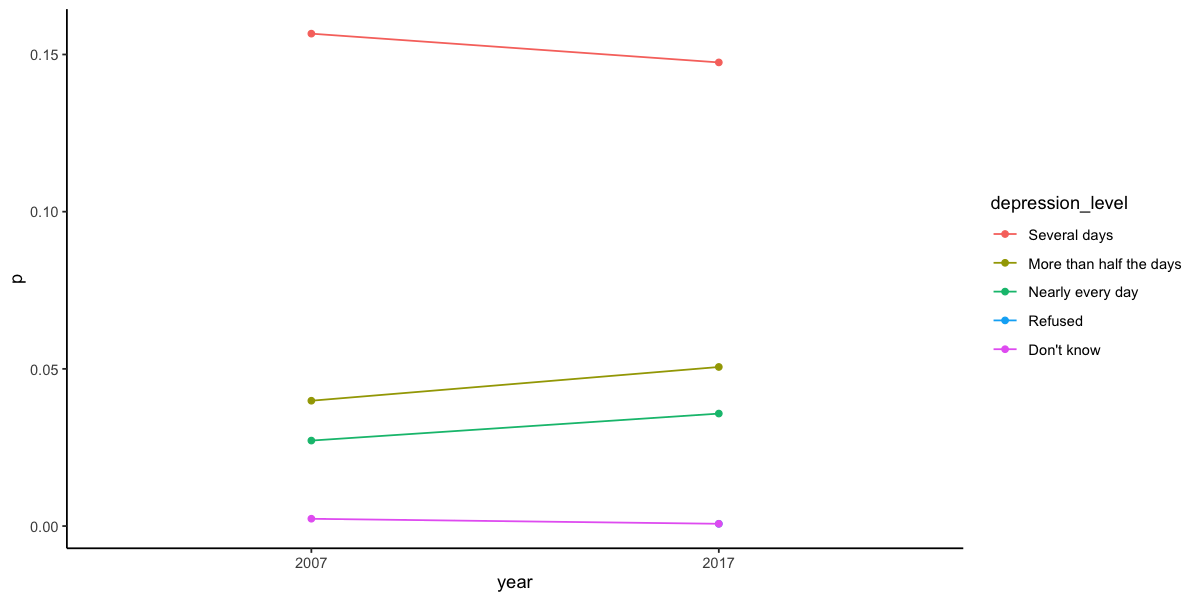

In [12]:
dep_df %>% count(year, depression_level) %>% 
    group_by(year) %>% mutate(p = n / sum(n)) %>% 
    filter(depression_level != "Not at all") %>% 
    ggplot(aes(x=year, y=p, group = depression_level, color = depression_level)) + 
    geom_line() + geom_point()

Are these differences statistically significant?

In [13]:
dep_df %>% lm(depression_level == "More than half the days" ~ year, data = .) %>% summary


Call:
lm(formula = depression_level == "More than half the days" ~ 
    year, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05497 -0.05497 -0.04386 -0.04386  0.95614 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.043861   0.002930  14.969  < 2e-16 ***
year2017    0.011105   0.004215   2.635  0.00844 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2163 on 10541 degrees of freedom
  (985 observations deleted due to missingness)
Multiple R-squared:  0.000658,	Adjusted R-squared:  0.0005632 
F-statistic: 6.941 on 1 and 10541 DF,  p-value: 0.008438


## Formula weighting
- An important issue we've overlooked is that samples in NHANES are not purely random. 
- To get a representative sample of the US, we have to pay attention to the "sampling weights" that are attached to each individual.
- These weights are contained inside the [demographics tables](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Demographics&CycleBeginYear=2007).
- (Note: the weighting procedure is [complicated](https://wwwn.cdc.gov/nchs/nhanes/tutorials/Weighting.aspx). I'm using a crude approximation here.)

This code downloads the demographic information tables. (This code is roughly the same as for downloading the depression tables).

In [14]:
demo_urls <- list(
    '2007'='https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2007/DataFiles/DEMO_E.XPT',
    '2017'='https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.XPT'
)
demo_urls %>% map(read_xpt) %>% map(recode_demo_df) %>% 
    lmap(\(lst) mutate(lst[[1]], year=names(lst)[1])) %>%
    bind_rows -> demo_df

demo_df




SEQN,WTINT2YR,Gender,Age_at_Screening,Age_in_Months_at_Screening,Race_Ethnicity,Served_in_Armed_Forces,Country_of_Birth,Citizenship_Status,Length_of_time_in_US,Education_Level_Adults,Marital_Status,Total_people_in_Household,Total_people_in_Family,Annual_Household_Income,year
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<chr>
41475,59356.356,Female,62,751,Other Race - Including Multi-Racial,No,USA,Citizen by birth or naturalization,NA,High school graduate/GED or equivalent,Married,2,2,"25,000-34,999",2007
41476,35057.218,Female,6,81,Other Race - Including Multi-Racial,NA,USA,Citizen by birth or naturalization,NA,NA,NA,6,6,"$100,000 and over",2007
41477,9935.266,Male,71,859,Non-Hispanic White,Yes,USA,Citizen by birth or naturalization,NA,High school graduate/GED or equivalent,Married,2,2,"20,000-24,999",2007
41478,12846.712,Female,1,17,Non-Hispanic White,NA,USA,Citizen by birth or naturalization,NA,NA,NA,4,4,"10,000-14,999",2007
41479,8727.798,Male,52,629,Mexican American,No,Mexico,Citizen by birth or naturalization,6,Less than 9th grade,Married,5,5,"45,000-54,999",2007
41480,7379.745,Male,6,81,Mexican American,NA,USA,Citizen by birth or naturalization,NA,NA,NA,7,4,"35,000-44,999",2007
41481,24342.505,Male,21,254,Non-Hispanic Black,No,USA,Citizen by birth or naturalization,NA,High school graduate/GED or equivalent,Never married,4,4,"25,000-34,999",2007
41482,9811.075,Male,64,778,Mexican American,No,Mexico,Not a citizen,7,9-11th grade (Includes 12th grade with no diploma),Married,6,6,"$100,000 and over",2007
41483,8058.685,Male,66,803,Non-Hispanic Black,Yes,USA,Citizen by birth or naturalization,NA,Some college or AA degree,Married,3,3,"20,000-24,999",2007


Finally, we will also download some information on [physical activity](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2017):

In [15]:
paq_urls <- list(
    '2007'='https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2007/DataFiles/PAQ_E.XPT',
    '2017'='https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/PAQ_J.XPT'
)

paq_urls %>% map(read_xpt) %>% map(recode_paq_df) %>% 
    lmap(\(lst) mutate(lst[[1]], year=names(lst)[1])) %>%
    bind_rows -> paq_df

Finally, join all three datasets:

In [16]:
nhanes_unw_df <- left_join(demo_df, dep_df) %>% left_join(paq_df)

Joining with `by = join_by(SEQN, year)`
Joining with `by = join_by(SEQN, year)`


Now generate a weighted sample:

In [17]:
set.seed(48109)

nhanes_wt_df <- nhanes_unw_df %>% 
    group_by(year) %>% 
    group_map(
        ~ sample_n(.x, 10000, replace = T, weight = WTINT2YR) %>% 
          mutate(year = factor(.y$year))
    ) %>% 
    bind_rows

nhanes_wt_df

SEQN,WTINT2YR,Gender,Age_at_Screening,Age_in_Months_at_Screening,Race_Ethnicity,Served_in_Armed_Forces,Country_of_Birth,Citizenship_Status,Length_of_time_in_US,⋯,trouble_concentrating,moving_or_speaking_slowly,thoughts_of_death,Moderate_Recreational_Activities,Days_Moderate_Recreational,Minutes_Vigorous_Work,Minutes_ModerateActivities,Minutes_SedentaryActivity,Walk_or_Bicycle,year
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,⋯,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
42576,24166.679,Male,28,343,Mexican American,No,Mexico,Not a citizen,4,⋯,Nearly every day,Not at all,Not at all,No,NA,600,NA,180,No,2007
49127,133946.351,Female,42,511,Non-Hispanic White,No,USA,Citizen by birth or naturalization,NA,⋯,Not at all,Not at all,Not at all,Yes,1,NA,20,240,No,2007
50181,86952.607,Male,26,320,Non-Hispanic White,No,USA,Citizen by birth or naturalization,NA,⋯,Not at all,Not at all,Not at all,No,NA,300,NA,30,No,2007
44965,69372.790,Female,22,269,Non-Hispanic White,No,USA,Citizen by birth or naturalization,NA,⋯,Not at all,Several days,Not at all,No,NA,15,NA,600,Yes,2007
48782,38465.605,Female,9,111,Non-Hispanic White,NA,USA,Citizen by birth or naturalization,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,2007
45925,55531.609,Male,68,827,Other Race - Including Multi-Racial,No,Other non-Spankish speaking country,Citizen by birth or naturalization,7,⋯,Not at all,Not at all,Not at all,Yes,1,NA,120,240,No,2007
46821,12962.965,Female,4,48,Mexican American,NA,USA,Citizen by birth or naturalization,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,2007
44101,28904.727,Female,2,26,Non-Hispanic White,NA,USA,Citizen by birth or naturalization,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,2007
51231,39214.086,Female,35,426,Non-Hispanic Black,No,Other non-Spankish speaking country,Not a citizen,4,⋯,Not at all,Not at all,Not at all,Yes,5,NA,10,600,No,2007


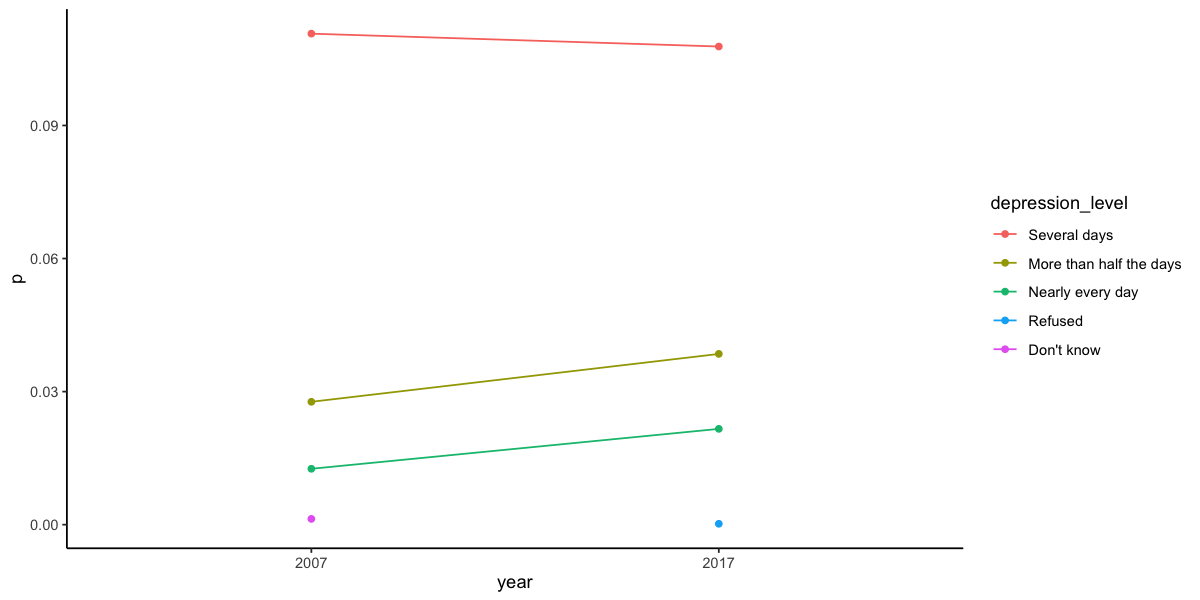

In [18]:
nhanes_wt_df %>% count(year, depression_level) %>% 
    group_by(year) %>% mutate(p = n / sum(n)) %>% 
    filter(depression_level != "Not at all") %>% 
    ggplot(aes(x=year, y=p, group = depression_level, color = depression_level)) + 
    geom_line() + geom_point()

In [19]:
nhanes_wt_df %>% lm(depression_level == "More than half the days" ~ year, data = .) %>% summary


Call:
lm(formula = depression_level == "More than half the days" ~ 
    year, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05581 -0.05581 -0.04193 -0.04193  0.95807 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.041925   0.002655  15.791  < 2e-16 ***
year2017    0.013888   0.003715   3.738 0.000186 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2158 on 13503 degrees of freedom
  (6495 observations deleted due to missingness)
Multiple R-squared:  0.001034,	Adjusted R-squared:  0.0009599 
F-statistic: 13.98 on 1 and 13503 DF,  p-value: 0.000186


In [20]:
xtabs(~ year + I(depression_level == "More than half the days"), data = nhanes_wt_df) %>% prop.test


	2-sample test for equality of proportions with continuity correction

data:  .
X-squared = 13.667, df = 1, p-value = 0.0002183
alternative hypothesis: two.sided
95 percent confidence interval:
 0.006480299 0.021295798
sample estimates:
   prop 1    prop 2 
0.9580748 0.9441867 


## Relationship between depression and age

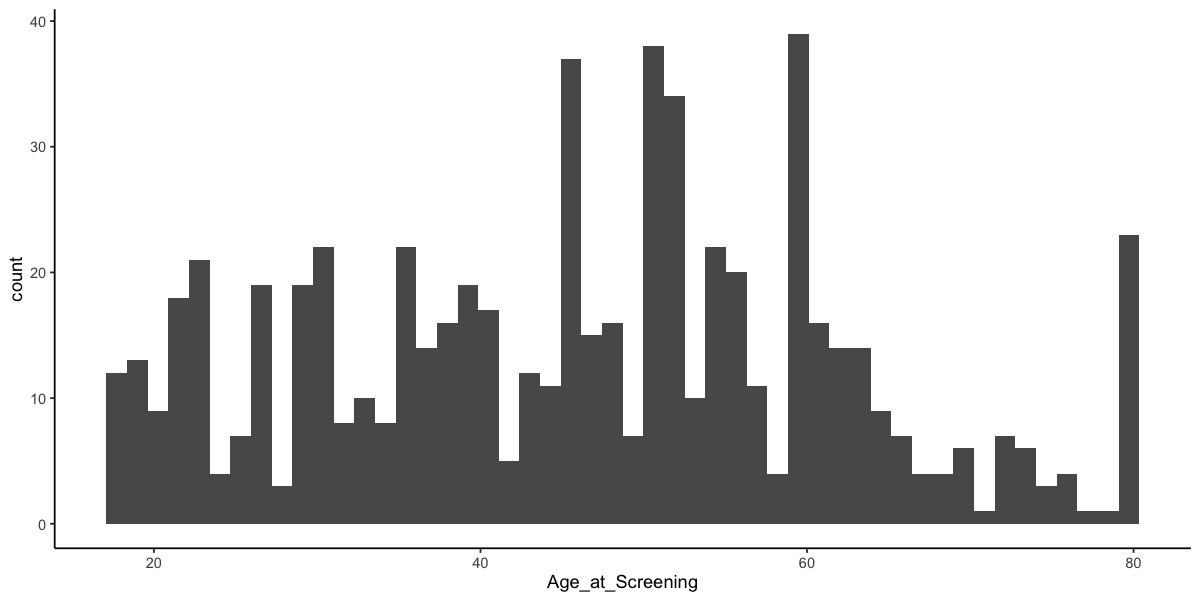

In [21]:
nhanes_wt_df %>% filter(depression_level == "More than half the days") %>% 
    ggplot + geom_histogram(aes(x = Age_at_Screening), bins=50)

In [22]:
nhanes_wt_df %>% 
    glm(depression_level == "More than half the days" ~ year, 
        data = ., family = "binomial") %>% 
    summary


Call:
glm(formula = depression_level == "More than half the days" ~ 
    year, family = "binomial", data = .)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.12904    0.06137 -50.984  < 2e-16 ***
year2017     0.30073    0.08073   3.725 0.000195 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5283.6  on 13504  degrees of freedom
Residual deviance: 5269.6  on 13503  degrees of freedom
  (6495 observations deleted due to missingness)
AIC: 5273.6

Number of Fisher Scoring iterations: 5


## Depression scoring
The variables we have about depression are:

In [23]:
select(nhanes_wt_df, depression_level:thoughts_of_death) %>% summary

                depression_level              depression_frequency
 Not at all             :10301   Not at all             :10281    
 Several days           : 2185   Several days           : 2357    
 More than half the days:  662   More than half the days:  485    
 Nearly every day       :  342   Nearly every day       :  373    
 Refused                :    2   Refused                :    1    
 Don't know             :   13   Don't know             :    1    
 NA's                   : 6495   NA's                   : 6502    
                  sleep_issue                   feeling_tired 
 Not at all             :7962   Not at all             :6543  
 Several days           :3407   Several days           :4754  
 More than half the days:1083   More than half the days:1125  
 Nearly every day       :1043   Nearly every day       :1071  
 Refused                :   1   Refused                :   3  
 Don't know             :   2   Don't know             :   2  
 NA's                  

Each question is score on a scale of 0-3, so we can sum them up to build a depression score.

In [24]:
nhanes_wt_df %>% 
    mutate(across(depression_level:thoughts_of_death, \(x) as.integer(x) - 1)) %>% 
    rowwise() %>% 
    mutate(dep_score = sum(c_across(depression_level:thoughts_of_death))) ->
    nhanes_depscore

Warning message:
“Removed 6506 rows containing non-finite outside the scale range
(`stat_count()`).”



Call:
lm(formula = dep_score ~ year, data = nhanes_depscore)

Residuals:
   Min     1Q Median     3Q    Max 
-3.155 -3.117 -1.155  0.883 41.845 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.15502    0.05012  62.952   <2e-16 ***
year2017    -0.03755    0.07011  -0.536    0.592    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.071 on 13492 degrees of freedom
  (6506 observations deleted due to missingness)
Multiple R-squared:  2.126e-05,	Adjusted R-squared:  -5.286e-05 
F-statistic: 0.2868 on 1 and 13492 DF,  p-value: 0.5923


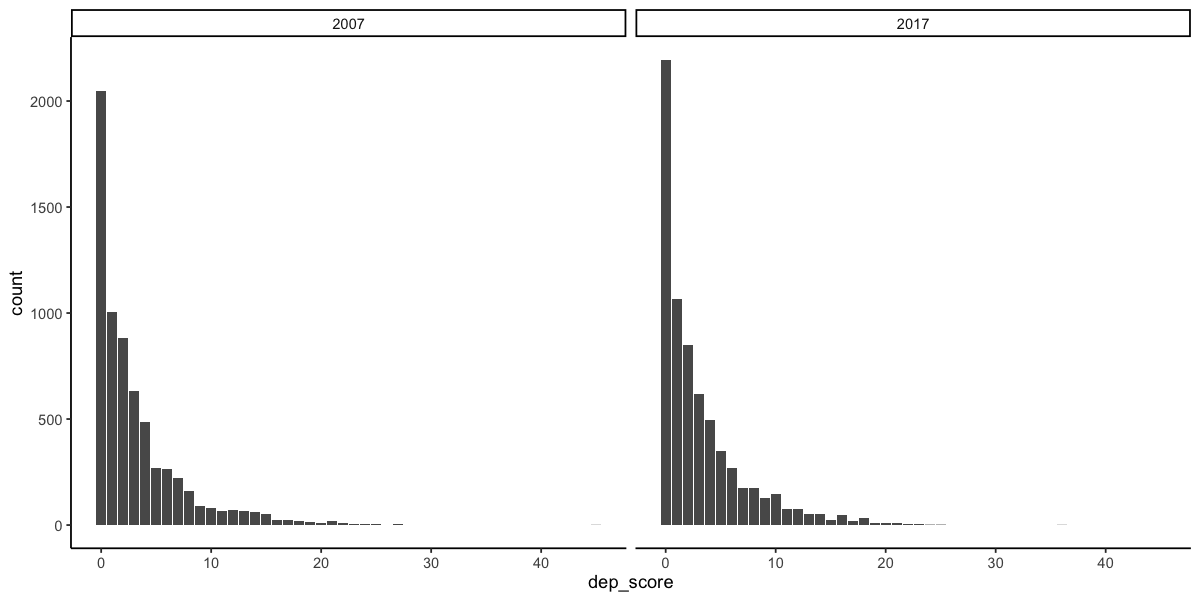

In [25]:
nhanes_depscore %>% ggplot + geom_bar(aes(x = dep_score)) + facet_grid(~ year)

lm(dep_score ~ year, data = nhanes_depscore) %>% summary

In [26]:
nhanes_depscore %>% lm(dep_score ~ year + Age_at_Screening + Gender, data = .) %>% summary


Call:
lm(formula = dep_score ~ year + Age_at_Screening + Gender, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-3.832 -2.646 -1.536  1.285 41.512 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.059150   0.110215  27.756   <2e-16 ***
year2017         -0.036552   0.069710  -0.524      0.6    
Age_at_Screening -0.008196   0.002020  -4.057    5e-05 ***
GenderFemale      0.920669   0.069679  13.213   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.043 on 13490 degrees of freedom
  (6506 observations deleted due to missingness)
Multiple R-squared:  0.01384,	Adjusted R-squared:  0.01362 
F-statistic: 63.09 on 3 and 13490 DF,  p-value: < 2.2e-16


In [27]:
nhanes_depscore %>% drop_na(dep_score, Age_in_Months_at_Screening) %>%
    mutate(age_q = factor(ntile(Age_in_Months_at_Screening, 10))) %>%
    lm(dep_score ~ age_q, data = .) %>% summary


Call:
lm(formula = dep_score ~ age_q, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-3.603 -2.757 -1.491  1.196 42.196 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.11599    0.16379  19.025   <2e-16 ***
age_q2      -0.38401    0.23163  -1.658   0.0974 .  
age_q3      -0.35893    0.23163  -1.550   0.1213    
age_q4       0.26803    0.23163   1.157   0.2473    
age_q5       0.48746    0.23163   2.104   0.0354 *  
age_q6       0.37461    0.23163   1.617   0.1059    
age_q7       0.41693    0.23163   1.800   0.0719 .  
age_q8       0.09561    0.23163   0.413   0.6798    
age_q9      -0.31191    0.23163  -1.347   0.1782    
age_q10     -0.22100    0.23163  -0.954   0.3401    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.137 on 6370 degrees of freedom
Multiple R-squared:  0.006059,	Adjusted R-squared:  0.004655 
F-statistic: 4.315 on 9 and 6370 DF,  p-value: 1.286e-05


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


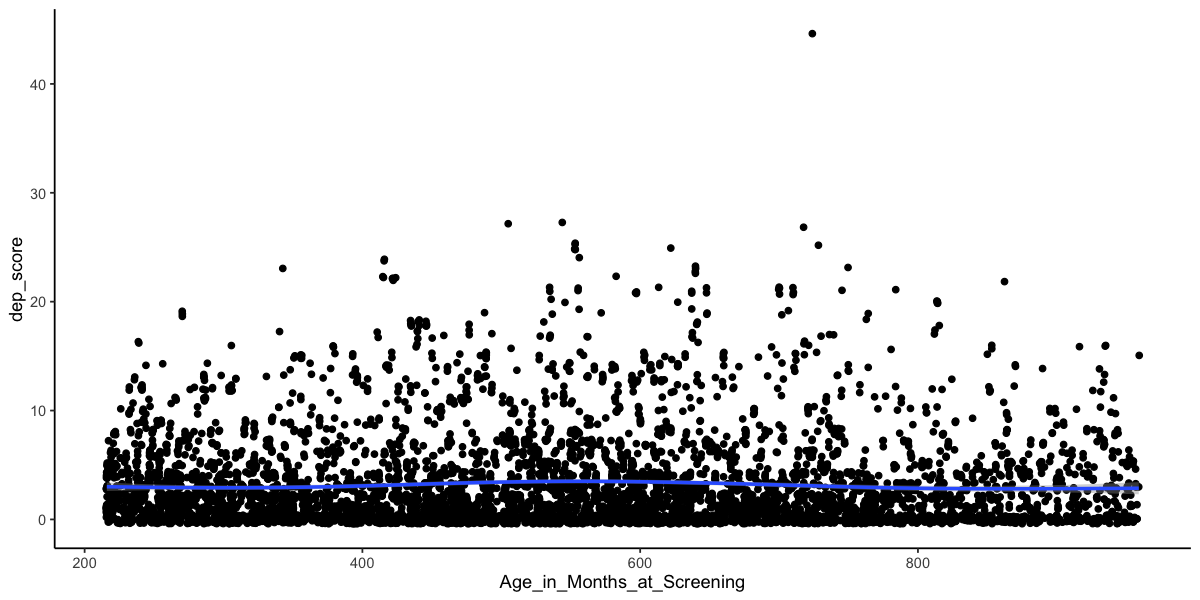

In [28]:
nhanes_depscore %>% drop_na(dep_score, Age_in_Months_at_Screening) %>% 
    ggplot(aes(x=Age_in_Months_at_Screening, y=dep_score)) + geom_jitter() +
    geom_smooth()

## Quantile regression
- Linear regression:

$$\mathbb{E}(Y \mid X) = X\beta$$

- Quantile:

$$Q_{Y|X}(\tau) = \inf \{y: F_{Y|X}(y) \ge \tau \}$$

- Quantile regression:

    
$$Q_{Y|X}(\tau) \approx X\beta,\text{ optimize over $\beta$.}$$

Note we would run a different regression for each value of $\tau$.

In [38]:
library(quantreg)

nhanes_depscore %>% 
    rq(dep_score ~ year + Age_at_Screening + Gender + Total_people_in_Household , 
       data = ., tau = 0.5) %>% summary

# nhanes_depscore %>% group_by(year) %>% summarize(quantile(dep_score, .99, na.rm=T))

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in summary.rq(.):
“768 non-positive fis”



Call: rq(formula = dep_score ~ year + Age_at_Screening + Gender + Total_people_in_Household, 
    tau = 0.5, data = .)

tau: [1] 0.5

Coefficients:
                          Value    Std. Error t value  Pr(>|t|)
(Intercept)                1.00000  0.13182    7.58600  0.00000
year2017                   0.00000  0.02953    0.00000  1.00000
Age_at_Screening           0.00000  0.00158    0.00000  1.00000
GenderFemale               1.00000  0.03088   32.38014  0.00000
Total_people_in_Household  0.00000  0.01143    0.00000  1.00000

## Depression and income
Are household income and depression related?

In [39]:
xtabs(~ Annual_Household_Income + year, nhanes_depscore)

                       year
Annual_Household_Income 2007 2017
     0-4,999             133  237
     5,000-9,999         313  190
     10,000-14,999       513  282
     15,000-19,999       575  427
     20,000-24,999       689  407
     25,000-34,999      1103  790
     35,000-44,999       897  937
     45,000-54,999       730  616
     55,000-64,999       624  564
     65,000-74,999       660  477
     Over $20,000        339  380
     Under $20,000        60   93
     $75,000 to $99,999 1187 1257
     $100,000 and over  1873 2560
     Refused             128  116
     Don't know          119  187

In [40]:
nhanes_depscore %>% 
    lm(dep_score ~ Annual_Household_Income, data = .) %>% 
    summary


Call:
lm(formula = dep_score ~ Annual_Household_Income, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-5.402 -2.403 -1.221  1.211 39.598 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                                4.61373    0.25783  17.895  < 2e-16
Annual_Household_Income5,000-9,999         0.78803    0.33451   2.356  0.01850
Annual_Household_Income10,000-14,999       0.17480    0.31159   0.561  0.57480
Annual_Household_Income15,000-19,999      -0.04274    0.29979  -0.143  0.88664
Annual_Household_Income20,000-24,999      -0.62061    0.29628  -2.095  0.03622
Annual_Household_Income25,000-34,999      -0.77863    0.28128  -2.768  0.00565
Annual_Household_Income35,000-44,999      -1.62571    0.28078  -5.790 7.20e-09
Annual_Household_Income45,000-54,999      -1.35975    0.28798  -4.722 2.36e-06
Annual_Household_Income55,000-64,999      -2.04141    0.29319  -6.963 3.49e-12
Annual_Household_Income65,000-74,999      -1

In [41]:
nhanes_dep_hhi <- nhanes_depscore %>% 
 mutate(Annual_Household_Income_Midpoint = case_when(
    Annual_Household_Income == "0-4,999" ~ 2500,
    Annual_Household_Income == "5,000-9,999" ~ 7500,
    Annual_Household_Income == "10,000-14,999" ~ 12500,
    Annual_Household_Income == "15,000-19,999" ~ 17500,
    Annual_Household_Income == "20,000-24,999" ~ 22500,
    Annual_Household_Income == "25,000-34,999" ~ 30000,
    Annual_Household_Income == "35,000-44,999" ~ 40000,
    Annual_Household_Income == "45,000-54,999" ~ 50000,
    Annual_Household_Income == "55,000-64,999" ~ 60000,
    Annual_Household_Income == "65,000-74,999" ~ 70000,
    Annual_Household_Income == "75,000-99,999" ~ 87500,
    Annual_Household_Income == "100,000 and Over" ~ 125000, # Assuming a midpoint for simplicity
    TRUE ~ NA_real_ # Default case if none of the above matches
  ))

In [42]:
lm(dep_score ~ Annual_Household_Income_Midpoint + Age_at_Screening + Gender + year, 
       data = nhanes_dep_hhi) %>% summary


Call:
lm(formula = dep_score ~ Annual_Household_Income_Midpoint + Age_at_Screening + 
    Gender + year, data = nhanes_dep_hhi)

Residuals:
   Min     1Q Median     3Q    Max 
-5.442 -2.941 -1.298  1.582 39.962 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       4.414e+00  1.810e-01  24.384   <2e-16 ***
Annual_Household_Income_Midpoint -3.656e-05  2.581e-06 -14.168   <2e-16 ***
Age_at_Screening                 -8.982e-04  2.723e-03  -0.330   0.7415    
GenderFemale                      9.524e-01  1.005e-01   9.479   <2e-16 ***
year2017                          1.833e-01  1.007e-01   1.821   0.0687 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.337 on 7503 degrees of freedom
  (12492 observations deleted due to missingness)
Multiple R-squared:  0.03908,	Adjusted R-squared:  0.03857 
F-statistic: 76.28 on 4 and 7503 DF,  p-value: < 2.2e-16


## Depression and military service
Are military service and depression related?

In [43]:
xtabs(~ Served_in_Armed_Forces + year, data = nhanes_depscore)

                      year
Served_in_Armed_Forces 2007 2017
            Yes         806  614
            No         6843 7215
            Refused       2    2
            Don't know    0    2

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1988 rows containing non-finite outside the scale range (`stat_bin()`).”


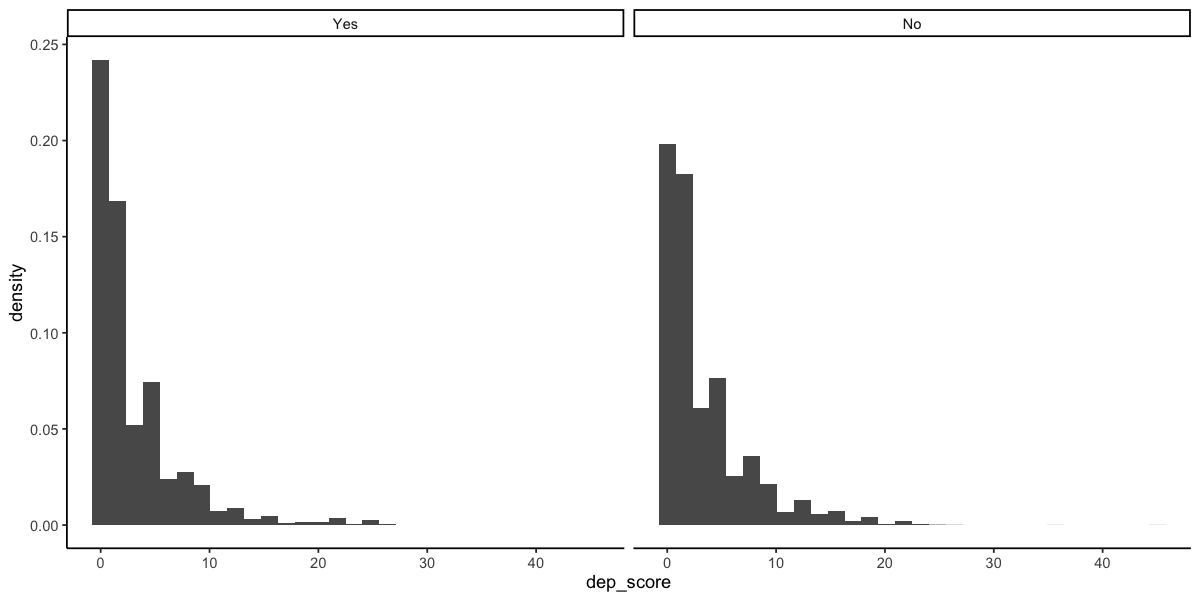

In [44]:
nhanes_depscore %>% filter(Served_in_Armed_Forces %in% c("Yes", "No")) %>% 
    ggplot + geom_histogram(aes(x = dep_score, y = ..density..)) + 
    facet_grid(~ Served_in_Armed_Forces) 

In [45]:
nhanes_depscore %>% filter(Served_in_Armed_Forces %in% c("Yes", "No")) %>% 
    lm(dep_score ~ year * Served_in_Armed_Forces, data = .) %>% 
    summary


Call:
lm(formula = dep_score ~ year * Served_in_Armed_Forces, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-3.196 -3.142 -1.196  0.858 41.804 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        2.83777    0.14845  19.116   <2e-16 ***
year2017                           0.02960    0.22574   0.131   0.8957    
Served_in_Armed_ForcesNo           0.35806    0.15770   2.270   0.0232 *  
year2017:Served_in_Armed_ForcesNo -0.08361    0.23752  -0.352   0.7248    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.071 on 13486 degrees of freedom
  (1988 observations deleted due to missingness)
Multiple R-squared:  0.0005786,	Adjusted R-squared:  0.0003562 
F-statistic: 2.602 on 3 and 13486 DF,  p-value: 0.05022


In [46]:
nhanes_depscore %>% filter(Served_in_Armed_Forces %in% c("Yes", "No")) %>% 
    rq(dep_score ~ year * Served_in_Armed_Forces, data = ., tau=0.99) %>% 
    summary


Call: rq(formula = dep_score ~ year * Served_in_Armed_Forces, tau = 0.99, 
    data = .)

tau: [1] 0.99

Coefficients:
                                  Value    Std. Error t value  Pr(>|t|)
(Intercept)                       21.00000  2.46024    8.53575  0.00000
year2017                          -2.00000  3.24362   -0.61659  0.53751
Served_in_Armed_ForcesNo          -3.00000  2.49948   -1.20025  0.23006
year2017:Served_in_Armed_ForcesNo  2.00000  3.28035    0.60969  0.54208

## Depression and exercise
How does exercise affect depression levels?

In [47]:
lm(dep_score ~ Walk_or_Bicycle + Age_at_Screening, data = nhanes_depscore) %>% summary


Call:
lm(formula = dep_score ~ Walk_or_Bicycle + Age_at_Screening, 
    data = nhanes_depscore)

Residuals:
   Min     1Q Median     3Q    Max 
-3.415 -2.983 -1.265  1.007 41.934 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         3.564449   0.105731  33.713  < 2e-16 ***
Walk_or_BicycleYes -0.184567   0.084147  -2.193   0.0283 *  
Age_at_Screening   -0.008305   0.002049  -4.053 5.09e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.069 on 13491 degrees of freedom
  (6506 observations deleted due to missingness)
Multiple R-squared:  0.001421,	Adjusted R-squared:  0.001273 
F-statistic: 9.598 on 2 and 13491 DF,  p-value: 6.835e-05


## Easily accessing the NHANES data
- `nhanesA` package was released on CRAN. 
- The goal of this package is to automate access to all of the data in NHANES.

In [39]:
# install.packages("nhanesA")
library(nhanesA)

nhanesTables('EXAM', 2015)

Data.File.Name,Data.File.Description
<chr>,<chr>
BPX_I,Blood Pressure
BMX_I,Body Measures
OHXDEN_I,Oral Health - Dentition
OHXREF_I,Oral Health - Recommendation of Care
FLXCLN_I,Fluorosis - Clinical
AUX_I,Audiometry
DXX_I,Dual-Energy X-ray Absorptiometry - Whole Body
AUXAR_I,Audiometry - Acoustic Reflex
AUXTYM_I,Audiometry - Tympanometry


### Getting the variables inside of a particular table

In [50]:
nhanesTableVars('EXAM', 'BMX_J')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,BMDSTATS,Body Measures Component status Code
2,BMIARMC,Arm Circumference Comment
3,BMIARML,Upper Arm Length Comment
4,BMIHEAD,Head Circumference Comment
5,BMIHIP,Hip Circumference Comment
6,BMIHT,Standing Height Comment
7,BMILEG,Upper Leg Length Comment
8,BMIRECUM,Recumbent Length Comment
9,BMIWAIST,Waist Circumference Comment


## Finding survey questions

In [51]:
# slow!
nhanesSearch("smoker", ystart=2001, ystop=2017, nchar=50)

Variable.Name,Variable.Description,Data.File.Name,Data.File.Description,Begin.Year,EndYear,Component,Use.Constraints
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SMD415,Total number of smokers inside home,SMQFAM_E,Smoking - Household Smokers,2007,2008,Questionnaire,None
SMD415A,Total # of cigarette smokers inside home,SMQFAM_E,Smoking - Household Smokers,2007,2008,Questionnaire,None
SMD415,Total number of smokers in home,SMQFAM_D,Smoking - Household Smokers,2005,2006,Questionnaire,None
SMD415A,Total # of cigarette smokers in home,SMQFAM_D,Smoking - Household Smokers,2005,2006,Questionnaire,None
SMD415,Total number of smokers in home,SMQFAM_C,Smoking - Household Smokers,2003,2004,Questionnaire,None
SMD415A,Total # of cigarette smokers in home,SMQFAM_C,Smoking - Household Smokers,2003,2004,Questionnaire,None
SMD415B,Total # of cigar smokers in home,SMQFAM_C,Smoking - Household Smokers,2003,2004,Questionnaire,None
SMD415C,Total # of pipe smokers in home,SMQFAM_C,Smoking - Household Smokers,2003,2004,Questionnaire,None
SMD415,Total number of smokers in home,SMQFAM_B,Smoking - Household Smokers,2001,2002,Questionnaire,None


## Downloading a table

In [52]:
demo_df <- nhanes('DEMO_J')
# head(demo_df)
nhanesTableVars('DEMO', 'DEMO_J')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,AIALANGA,Language of the MEC ACASI Interview Instrument
2,DMDBORN4,In what country {were you/was SP} born?
3,DMDCITZN,{Are you/Is SP} a citizen of the United States? [Information about citizenship is being collected by the U.S. Public Health Serv
4,DMDEDUC2,What is the highest grade or level of school {you have/SP has} completed or the highest degree {you have/s/he has} received?
5,DMDEDUC3,What is the highest grade or level of school {you have/SP has} completed or the highest degree {you have/s/he has} received?
6,DMDFMSIZ,Total number of people in the Family
7,DMDHHSIZ,Total number of people in the Household
8,DMDHHSZA,Number of children aged 5 years or younger in the household
9,DMDHHSZB,Number of children aged 6-17 years old in the household


## Assessing CVD in NHANES
- The report asks you to use NHANES to study cardiovascular disease (CVD).
- CVD is an umbrella term for several different conditions, including: coronary artery disease, peripheral artery disease, heart failure, hypertension.
- Diagnosis: Involves a combination of clinical assessment, laboratory tests, and imaging:
  - Clinical assessment: patient history, physical examination
  - Lab tests: Blood tests to measure cholesterol, glucose, and other markers
  - Imaging: Echocardiogram, angiogram, CT scans, and MRIs to visualize heart and vascular system
- **Not all of these are measured in NHANES, but many things that are correlated with them are**.

In [53]:
nhanesSearch("cvd", ystart=2001, ystop=2008, nchar=50)

No matches found



NULL

## Determining CVD risk from NHANES
- A number of studies have used NHANES data to study CVD in the U.S..
- Example: [Status of Cardiovascular Health in US Adults and Children Using the American Heart Association’s New “Life’s Essential 8” Metrics: Prevalence Estimates From the National Health and Nutrition Examination Survey (NHANES), 2013 Through 2018](https://www.ahajournals.org/doi/epub/10.1161/CIRCULATIONAHA.122.060911)

## Life's essential 8

- 4 health factors: body mass index (BMI), blood glucose levels, blood lipid levels, and blood pressure;
- 4 health behaviors: smoking status, physical activity, diet, and sleep

- Source: [Life’s Essential 8: Updating and Enhancing the American Heart Association’s Construct of Cardiovascular Health: A Presidential Advisory From the American Heart Association](https://www.ahajournals.org/doi/10.1161/CIR.0000000000001078)

- Can we define an LE8 score using NHANES data?
- A number of studies have done this using somewhat complicated methodologies ([example](https://www.ahajournals.org/action/downloadSupplement?doi=10.1161%2FCIRCULATIONAHA.122.060911&file=CIRC_CIRCULATIONAHA-2022-060911_supp1.pdf))
- In the time we have during lecture, I'm going to focus on calculating a simplified LE8 score.

## Health factors
- The four health factors *are* directly measured, so they are somewhat easier to calculate.

In [55]:
# body mass index
 bmx_df = nhanes('BMX_J')

bmx_df$BMXBMI %>% ntile(100)

 nhanesCodebook('BMX_J', 'BMXBMI')


[1]  15   7  77  30  17  39  93  NA  29  23  38  94  34  73  43  32  51  NA
  [19]  88  40  34   3   9  75  40  82  59  64  59  29  24  87  17  19  83  11
  [37]  73  14  84  34  28   3  45  32  NA  NA  47  48  44  82  68  67  86  73
  [55]  67  91  66  57  48  NA  31  57  78  50   4  51   1  73  41  51  51  33
  [73]  NA  58  10  82  48  41  42  12  73  33  93  39   4  90  20  64  40   7
  [91]  75  78  64  35  35  45  19  24  NA  84  63  95  61  NA  66  68  75  97
 [109]  60  61  NA  42  63  60  58  28  22  82  63  72  24  11  77  79  48  56
 [127]   3  89  22  93  46  71  41  80   3  28  45  45  23  95  66  35  56  75
 [145]  57  51  NA  88  96  10  12  34  76  19  76  41  NA  32  16  87  36  20
 [163]  29  74   1  45  45  45  41  11   9  24  96  29   6  50  29  40  98  88
 [181]  62  60  84  71  53  16  70  74  50  59  79  65  21  67  55  57  45  26
 [199] 100  45  85  42  45  16  73   1  27   4  34  72  49  14  89  43   1  56
 [217]  69  87  75  NA  NA  NA  80  39  65  45  63  84   8  37  30  50  15  44
 [235]  86  NA  91  94  36  NA  67   2  48  95  NA  81  65  34  NA  NA  52  34
 [253]  46  92  69  48  68  57  NA  70  28  48  21  55  26  80  77  56   5  93
 [271]  18  29  91  55  15  19  NA  24  21  16  25  46  26  95  49  71  30  21
 [289]  40  86  24  52  12  47  34   1  52  30  77  53  12  85  NA  17   4  49
 [307]  63  31  46  65  51  44  67  77  72  25  53  72  69  78  34  38  33  31
 [325]  52  65  88  30 100  58  67   2  91  72  26   5  79  98  75  95  81  12
 [343]  17  94  58  NA  88  62  75   7  54  NA  86  26  34  20  52  NA  33  45
 [361]  33   8  66  47  42  NA  49  81  19  57  85  98  66  55  88  72  85  NA
 [379]  69   6  20  61  36  29  53  44   5  12  61  38  14  NA  46 100  55  38
 [397]  43  49  60  79  83  48  92  20  54  98  30  40  65  51   8  43  47  78
 [415]  84  43   1   9  95  76  18  10  76  84  60  29   2  38  92  65  18  89
 [433]  37  36  31  41  44  27  14  76  15  79  51   9  23  13  83  50  52  60
 [451]  51  97  99  58  77  37  98   4  17  19  69  94  50  14  96  95   6   7
 [469]  NA  74  63  31  91  38  90  16  91  57  73  98  NA  42  19  32  32  NA
 [487]  71  52   1  35  54  39   9  68  89  20  10  79  NA  94  33  59  45  21
 [505]  38  47  89  24  71  46  62  54  63  98  78  84  96  45  98  90  37  76
 [523]  10   5  65  36  85  36  22  22  12  94  55  45  25  41  46  97  45  71
 [541]  81  74  43  63  50  42  20  94  72  98  51  97  37  87  82  60  27  70
 [559]  71  80  NA  80  44  88  51  45  28  38  52  19  14  18  76  NA  64  20
 [577]  99  39  NA  11   4  53  24  81  67  65  76  98  82  NA  21  11  91   2
 [595]  NA  63  63  98  29  76  85  69  85  84   7  97  NA  NA  94  26  64  38
 [613]  65  23  53  12  59   5  NA  74  77  81  60  58  25  48   2  48   4  NA
 [631]  47  90  49  85  30  63  99  15  65  64  60  20  25  NA  53  92  99  81
 [649]   5  87  NA  46  68  95  82  19  NA  72  85   1  49  61   3  33  75  97
 [667]  75  22  22  72  21  61  51  95  36  82   8  88   4  71  50  17  31  55
 [685]  71  NA  91  96  94 100 100  89  89  58  NA  74  NA  41   5  NA  29  71
 [703]  95  44  77  15  84  NA  80   2  74  NA  19  89  46  84  99  64  56  36
 [721]  96  91  74  NA  30  NA  93  68  68   7  73  36  19  42  13  34  81   8
 [739]  81  43  75  20  NA  75  71  53   7  41  94  14  60   7   4   7  65  35
 [757]  34  87  87  85  21  42  25  89  98  73  53  80  34  48   8  19  98  45
 [775]  68  NA  69  13  NA  77  54  82  78  45 100  30  52  69  71  63  30  34
 [793]  50  72  22  30  NA  45  30  60  44  25   7  62  38  NA  42  66  56  40
 [811]   3  86  39  90  88   9  14  24  46  82  51  70  47  83  49  13  56  99
 [829]  28  90  22  54  60   8  NA  29  11   4  24  25   5  72  84  62  NA  NA
 [847]  98  30  41   6  15  61  85  14  27  21  77  50  70  43  45  46  45  48
 [865]  14  91  92   7  80  54  NA   4  11  40  50  33  60  91   4   6  97  51
 [883]  61  50  48   3  50  19  81  17  77  30  89  10  20  NA  35  28  85  65
 [901]  95  61  53   3   4  18  29  54  80  NA  NA  3

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<lgl>
12.3 to 86.2,Range of Values,8005,8005,NA
.,Missing,699,8704,NA


Joining with `by = join_by(SEQN)`
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1249 rows containing non-finite outside the scale range (`stat_bin()`).”


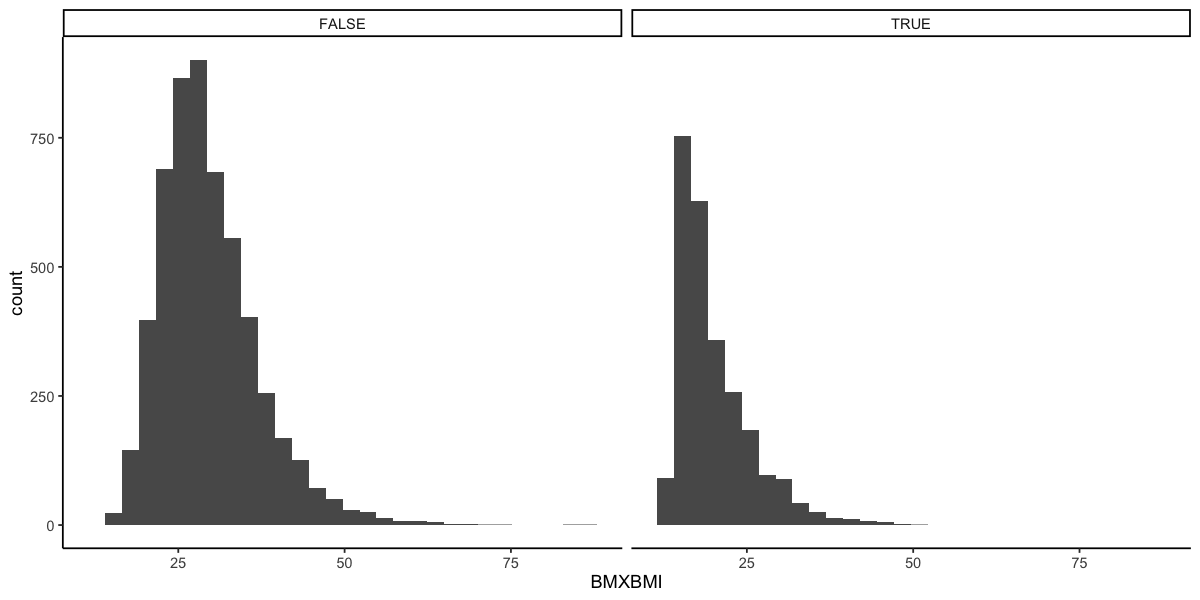

In [56]:
demo_df %>% left_join(bmx_df) %>% mutate(child = RIDAGEYR < 18) %>% 
    ggplot() + geom_histogram(aes(x = BMXBMI)) + facet_grid(~ child)

In [57]:
# blood glucose levels?
nhanesSearch("glucose")

Variable.Name,Variable.Description,Data.File.Name,Data.File.Description,Begin.Year,EndYear,Component,Use.Constraints
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GTDBL2MN,Time from fasting glucose & OGTT (min),OGTT_E,Oral Glucose Tolerance Test,2007,2008,Laboratory,None
GTDDR1MN,Time from fast glucose & challenge (min),OGTT_E,Oral Glucose Tolerance Test,2007,2008,Laboratory,None
GTDDR2MN,Time from glucose challenge & OGTT(min),OGTT_E,Oral Glucose Tolerance Test,2007,2008,Laboratory,None
GTXDRANK,Amount of glucose challenge drank,OGTT_E,Oral Glucose Tolerance Test,2007,2008,Laboratory,None
LBXGLUSI,Plasma glucose: SI(mmol/L),LAB10AM,"Plasma Fasting Glucose, Serum C-peptide & Insulin",1999,2000,Laboratory,None
LBXGLT,Two hour oral glucose tolerance (OGTT) (mg/dL),OGTT_D,Oral Glucose Tolerance Test,2005,2006,Laboratory,None
LBDGLUSI,Plasma glucose: SI(mmol/L),L10AM_C,"Plasma Fasting Glucose, Serum C-peptide & Insulin",2003,2004,Laboratory,None
LBXGLUSI,Plasma glucose: SI(mmol/L),L10AM_B,"Plasma Fasting Glucose, Serum C-peptide & Insulin",2001,2002,Laboratory,None
LB2GLU,Plasma glucose (mg/dL),L10_2_B,"Glycohemoglobin, Plasma Glucose, Serum C-peptide, & Insulin, Second Exam",2001,2002,Laboratory,None


In [58]:
nhanesCodebook('GLU_J', 'LBXGLU')

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<lgl>
47 to 451,Range of Values,2891,2891,NA
.,Missing,145,3036,NA


Warning message:
“Removed 145 rows containing non-finite outside the scale range (`stat_bin()`).”


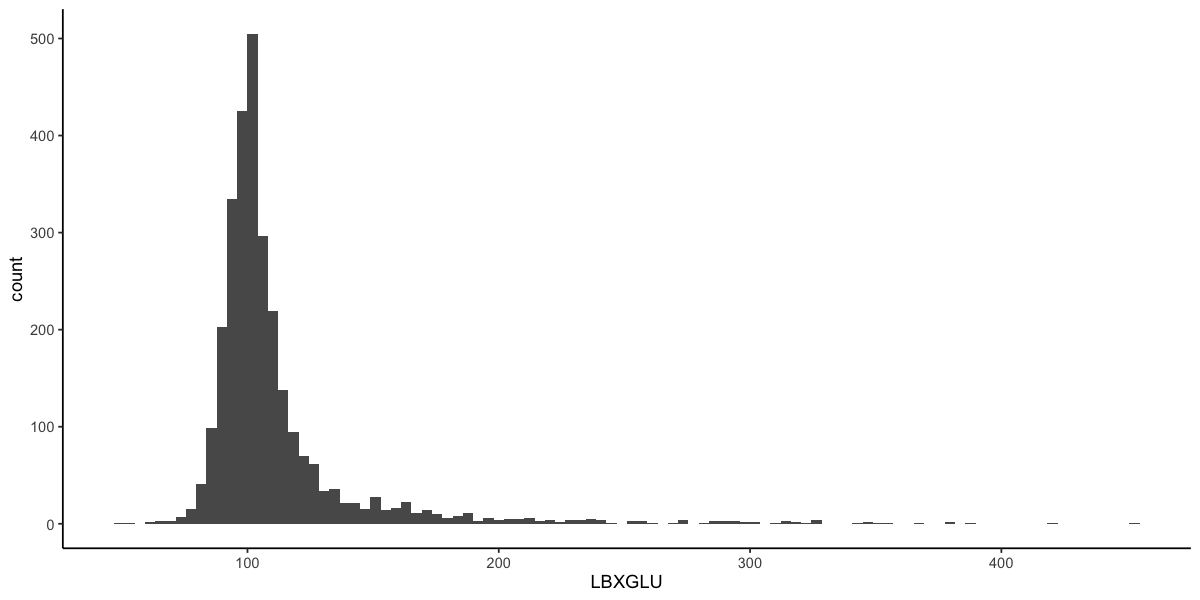

In [66]:
glu_df <- nhanes("GLU_J")
glu_df %>% ggplot + geom_histogram(aes(x=LBXGLU), bins=100)

In [67]:
nhanesCodebook('GLU_J', 'LBXGLU')

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<lgl>
47 to 451,Range of Values,2891,2891,NA
.,Missing,145,3036,NA


In [68]:
## lipid levels
nhanesSearch("LDL")

Variable.Name,Variable.Description,Data.File.Name,Data.File.Description,Begin.Year,EndYear,Component,Use.Constraints
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LBDLDL,LDL-cholesterol (mg/dL),TRIGLY_E,Cholesterol - LDL & Triglycerides,2007,2008,Laboratory,None
LBDLDLSI,LDL-cholesterol (mmol/L),TRIGLY_E,Cholesterol - LDL & Triglycerides,2007,2008,Laboratory,None
LBDLDL,LDL-cholesterol (mg/dL),LAB13AM,Cholesterol - LDL & Triglycerides,1999,2000,Laboratory,None
LBDLDLSI,LDL-cholesterol (mmol/L),LAB13AM,Cholesterol - LDL & Triglycerides,1999,2000,Laboratory,None
LB2LDL,LDL-cholesterol (mg/dL),l13_2_b,"Cholesterol - Total, HDL, LDL & Triglycerides, Second Exam",2001,2002,Laboratory,None
LB2LDLSI,LDL-cholesterol (mmol/L),l13_2_b,"Cholesterol - Total, HDL, LDL & Triglycerides, Second Exam",2001,2002,Laboratory,None
LBDLDL,LDL-cholesterol (mg/dL),TRIGLY_D,"Cholesterol - LDL, Triglyceride & Apoliprotein (ApoB)",2005,2006,Laboratory,None
LBDLDLSI,LDL-cholesterol (mmol/L),TRIGLY_D,"Cholesterol - LDL, Triglyceride & Apoliprotein (ApoB)",2005,2006,Laboratory,None
LBDLDL,LDL-cholesterol (mg/dL),L13AM_C,Cholesterol - LDL & Triglycerides,2003,2004,Laboratory,None


In [69]:
chol_df <- nhanes("TRIGLY_J")
 head(chol_df)

 ntile(chol_df$LBDLDL, 100) %>% head
# ntile(log(chol_df$LBDLDLSI), 100) %>% head


,SEQN,WTSAF2YR,LBXTR,LBDTRSI,LBDLDL,LBDLDLSI,LBDLDLM,LBDLDMSI,LBDLDLN,LBDLDNSI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,93708,25653.68,58,0.655,109,2.819,107,2.767,111,2.870
2,93711,29226.05,48,0.542,156,4.034,152,3.931,158,4.086
3,93717,137150.99,102,1.152,140,3.620,138,3.569,142,3.672
4,93718,58883.31,46,0.519,80,2.069,77,1.991,79,2.043
5,93719,0.00,80,0.903,35,0.905,35,0.905,35,0.905
6,93721,17154.99,79,0.892,61,1.577,61,1.577,61,1.577


[1] 56 92 84 23  1  7

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 228 rows containing non-finite outside the scale range (`stat_bin()`).”


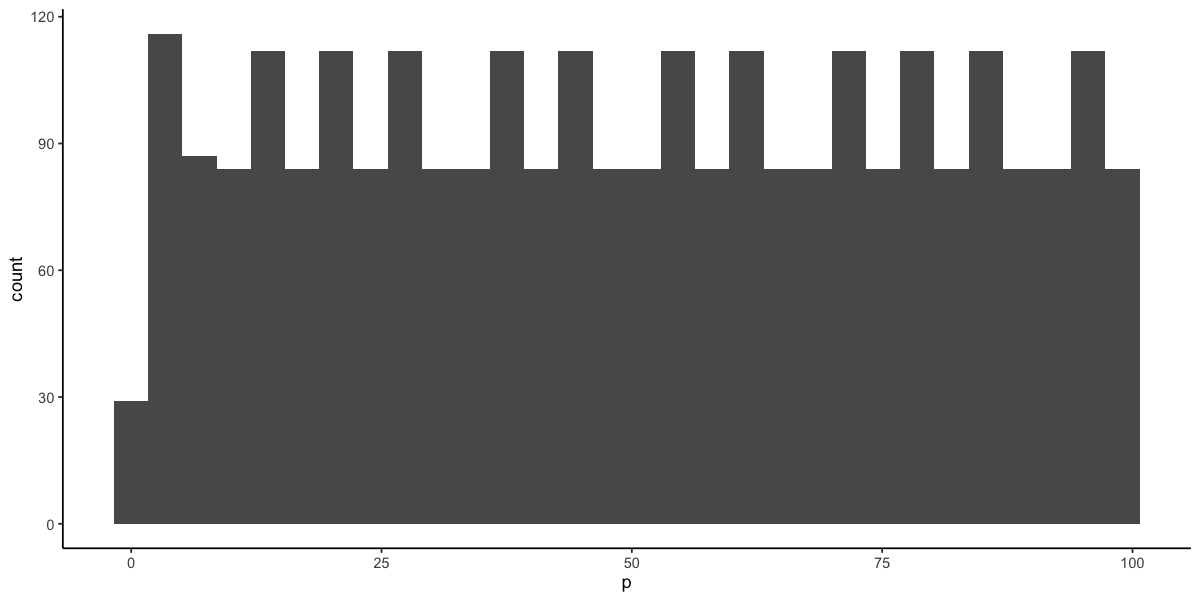

In [70]:
chol_df %>% mutate(p = ntile(LBDLDL, 100)) %>% ggplot + geom_histogram(aes(x=p))

In [71]:
# blood pressure
bpx_df = nhanes('BPX_J')

Warning message:
“Removed 2402 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2402 rows containing non-finite outside the scale range (`stat_bin()`).”


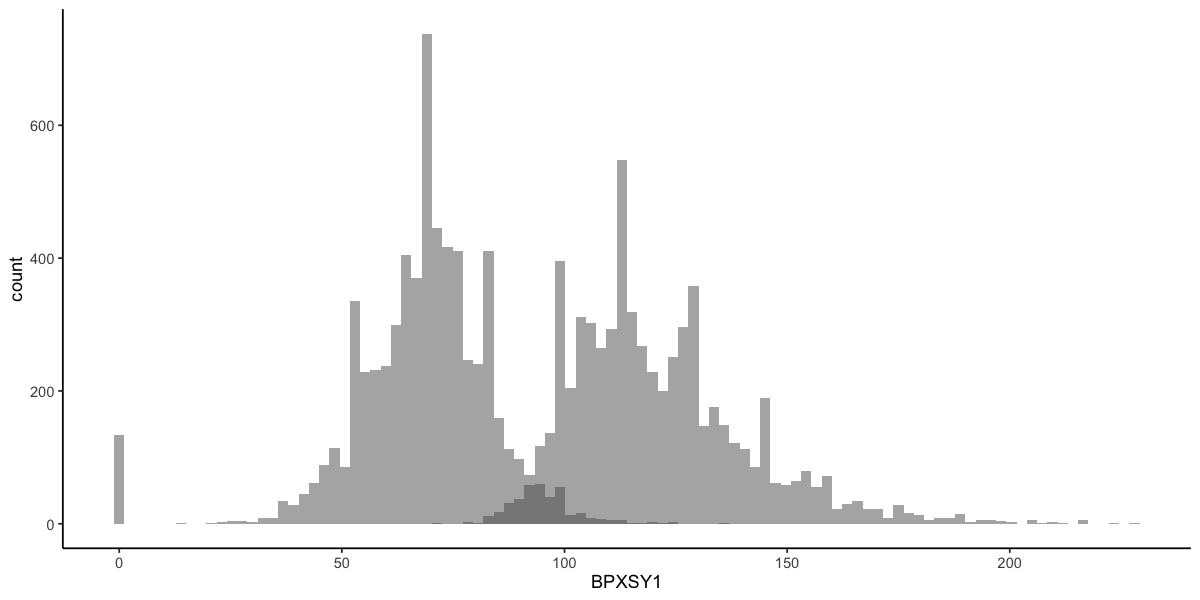

In [72]:
bpx_df %>% ggplot +
    geom_histogram(aes(x=BPXSY1), alpha=0.5, bins=100) + 
    geom_histogram(aes(x=BPXDI1), alpha=0.5, bins=100)

Let's merge everything together to form the overall health factor score:

In [73]:
hf_df <- reduce(list(demo_df, bmx_df, glu_df, chol_df, bpx_df), left_join, by = "SEQN")

hf_df

SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,⋯,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4
<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,⋯,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
93703,NHANES 2017-2018 public release,Both interviewed and MEC examined,Female,2,NA,Other Race - Including Multi-Racial,Non-Hispanic Asian,May 1 through October 31,27,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
93704,NHANES 2017-2018 public release,Both interviewed and MEC examined,Male,2,NA,Non-Hispanic White,Non-Hispanic White,November 1 through April 30,33,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
93705,NHANES 2017-2018 public release,Both interviewed and MEC examined,Female,66,NA,Non-Hispanic Black,Non-Hispanic Black,May 1 through October 31,NA,⋯,NA,NA,NA,NA,202,62,No,198,74,No
93706,NHANES 2017-2018 public release,Both interviewed and MEC examined,Male,18,NA,Other Race - Including Multi-Racial,Non-Hispanic Asian,May 1 through October 31,222,⋯,No,114,70,No,108,76,No,NA,NA,NA
93707,NHANES 2017-2018 public release,Both interviewed and MEC examined,Male,13,NA,Other Race - Including Multi-Racial,Other Race - Including Multi-Racial,May 1 through October 31,158,⋯,No,128,46,No,128,58,No,NA,NA,NA
93708,NHANES 2017-2018 public release,Both interviewed and MEC examined,Female,66,NA,Other Race - Including Multi-Racial,Non-Hispanic Asian,May 1 through October 31,NA,⋯,NA,138,78,No,144,76,No,144,74,No
93709,NHANES 2017-2018 public release,Both interviewed and MEC examined,Female,75,NA,Non-Hispanic Black,Non-Hispanic Black,November 1 through April 30,NA,⋯,No,118,66,No,118,68,No,NA,NA,NA
93710,NHANES 2017-2018 public release,Both interviewed and MEC examined,Female,0,11,Non-Hispanic White,Non-Hispanic White,May 1 through October 31,13,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
93711,NHANES 2017-2018 public release,Both interviewed and MEC examined,Male,56,NA,Other Race - Including Multi-Racial,Non-Hispanic Asian,May 1 through October 31,NA,⋯,No,94,68,No,102,64,No,NA,NA,NA


In [74]:
health_df <- hf_df %>% mutate(
    health_score = (
        ntile(BMXBMI, 100) +
        ntile(LBXGLU, 100) +
        ntile(LBDLDL, 100) +
        (ntile(BPXSY1, 100) + ntile(BPXDI1, 100)) / 2
    )
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 6795 rows containing non-finite outside the scale range (`stat_bin()`).”


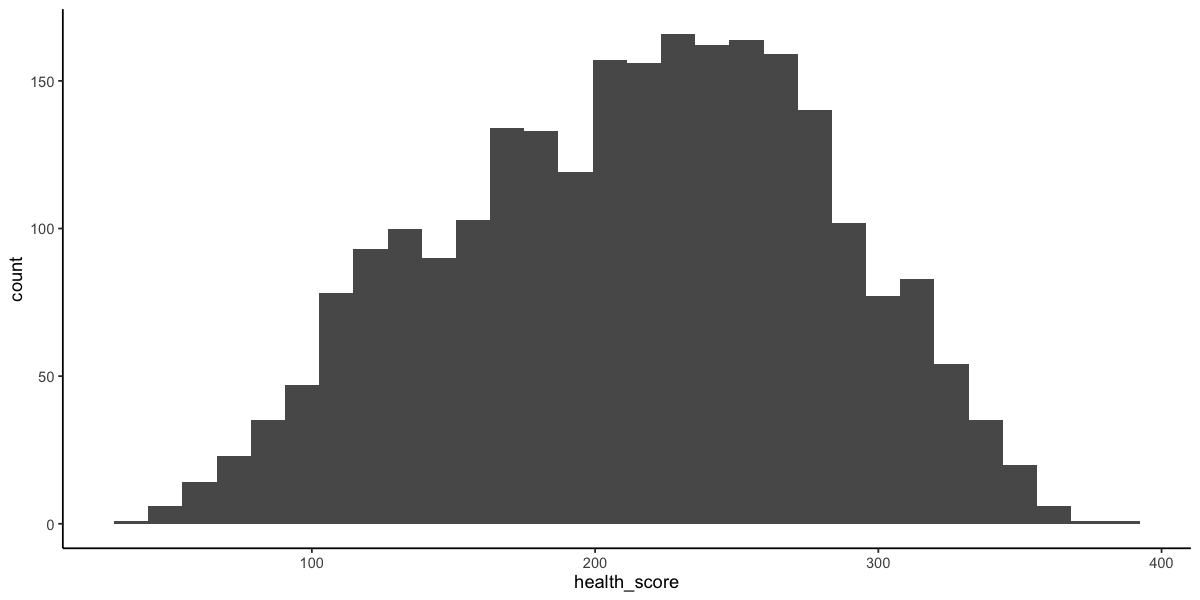

In [75]:
ggplot(health_df) + geom_histogram(aes(x = health_score))

## Behavior factors
- Recall the four behavior factors we want to measure:
    - smoking status
    - physical activity
    - diet
    - sleep
- AFAICT, the AHA does not endorse any particular way to score these. It's up to us to decide how!

In [76]:
# smoking status
smq_df = nhanes('SMQ_J')
head(smq_df)

,SEQN,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD057,SMQ078,SMD641,SMD650,⋯,SMQ848,SMQ852Q,SMQ852U,SMQ890,SMQ895,SMQ900,SMQ905,SMQ910,SMQ915,SMAQUEX2
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>
1,93705,Yes,16,Not at all,30,Years,5,NA,NA,NA,⋯,NA,NA,NA,No,NA,No,NA,No,NA,Home Interview (18+ Yrs)
2,93706,No,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,No,NA,No,NA,No,NA,Home Interview (18+ Yrs)
3,93707,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,ACASI (12 - 17 Yrs)
4,93708,No,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,No,NA,No,NA,No,NA,Home Interview (18+ Yrs)
5,93709,Yes,15,Every day,NA,NA,NA,Within 5 minutes,30,5,⋯,NA,NA,NA,Yes,0,Yes,0,Yes,0,Home Interview (18+ Yrs)
6,93711,No,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,No,NA,No,NA,No,NA,Home Interview (18+ Yrs)


What do all these variables represent?

In [77]:
nhanesTableVars('Q', 'SMQ_J')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,SEQN,Respondent sequence number.
2,SMAQUEX2,Questionnaire Mode Flag
3,SMD030,How old {were you/was SP} when {you/s/he} first started to smoke cigarettes fairly regularly?
4,SMD057,"At that time, about how many cigarettes did {you/SP} usually smoke per day?"
5,SMD093,May I please see the pack for the brand of cigarettes {you usually smoke/SP usually smokes}.
6,SMD100BR,BRAND OF CIGARETTES SMOKED BY SP (SUB-BRAND INCLUDED IF APPLICABLE AND AVAILABLE)
7,SMD100CO,CIGARETTE CARBON MONOXIDE CONTENT
8,SMD100FL,CIGARETTE PRODUCT FILTERED OR NON-FILTERED
9,SMD100LN,CIGARETTE PRODUCT LENGTH


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5661 rows containing non-finite outside the scale range (`stat_bin()`).”


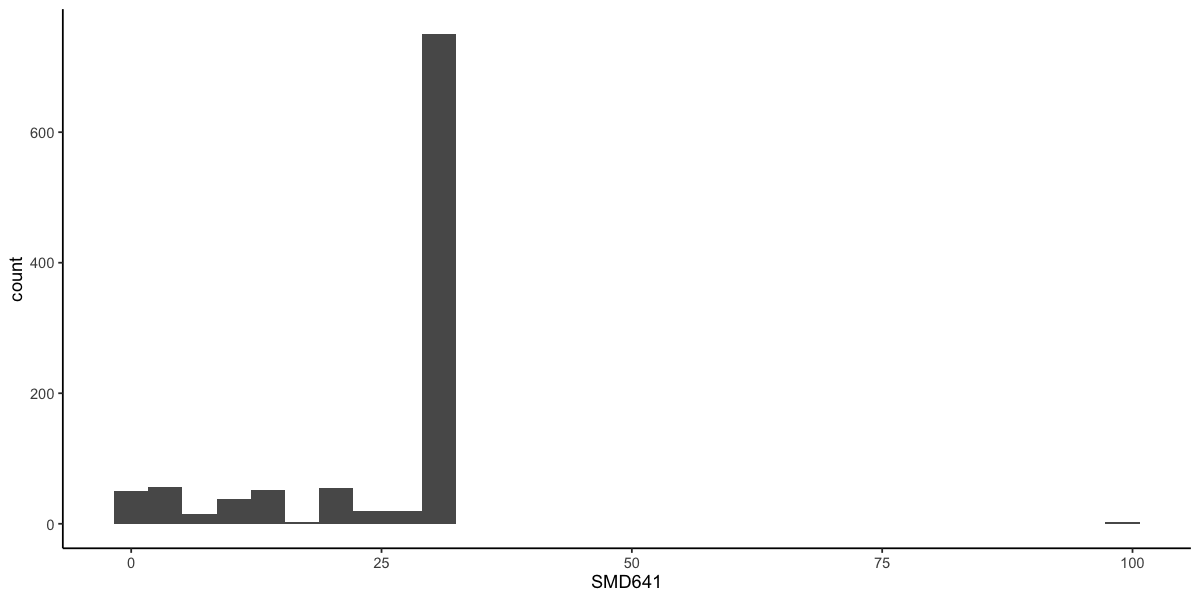

In [78]:
smq_df %>% ggplot + geom_histogram(aes(x=SMD641))

(There is a weird outlier here at x=99. What does it represent?)

In [79]:
nhanesCodebook('SMQ_J', 'SMD641')

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<lgl>
0 to 30,Range of Values,1060,1060,NA
77,Refused,0,1060,NA
99,Don't know,3,1063,NA
.,Missing,5661,6724,NA


In [80]:
nhanesCodebook('SMQ_J', 'SMQ020')
smq_df %>% pluck("SMQ020") %>% table

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<chr>
1,Yes,2359,2359,
2,No,3497,5856,SMQ890
7,Refused,0,5856,SMQ890
9,Don't know,0,5856,SMQ890
.,Missing,868,6724,


.
 Yes   No 
2359 3497 

In [81]:
smq_df <- mutate(smq_df, smoking_score = ifelse(SMQ020 == 1, 100, 0))

### Physical activity

In [82]:
paq_df <- nhanes('PAQ_J')
nhanesTableVars('Q', 'PAQ_J')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,PAD615,How much time {do you/does SP} spend doing vigorous-intensity activities at work on a typical day?
2,PAD630,How much time {do you/does SP} spend doing moderate-intensity activities at work on a typical day?
3,PAD645,How much time {do you/does SP} spend walking or bicycling for travel on a typical day?
4,PAD660,"How much time {do you/does SP} spend doing vigorous-intensity sports, fitness or recreational activities on a typical day?"
5,PAD675,"How much time {do you/does SP} spend doing moderate-intensity sports, fitness or recreational activities on a typical day?"
6,PAD680,"The following question is about sitting at school, at home, getting to and from places, or with friends including time spent sit"
7,PAQ605,Next I am going to ask you about the time {you spend/SP spends} doing different types of physical activity in a typical week. Th
8,PAQ610,"In a typical week, on how many days {do you/does SP} do vigorous-intensity activities as part of {your/his/her} work?"
9,PAQ620,Does {your/SP's} work involve moderate-intensity activity that causes small increases in breathing or heart rate such as brisk w


In [83]:
nhanesCodebook('PAQ_J', 'PAD680')

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<lgl>
0 to 1320,Range of Values,5811,5811,NA
7777,Refused,0,5811,NA
9999,Don't know,35,5846,NA
.,Missing,10,5856,NA


In [84]:
paq_df <- paq_df %>% filter(PAD680 < 1400) %>% mutate(activity_score = ntile(PAD680, 100))

## Diet
- In my research this one was the most complicated to define.
- Several studies ([example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7284419/#:~:text=The%20DASH%20score%20is%20divided,were%20reported%20per%201000%20kcal.)) use the DASH scoring system. 
- It was hard to figure out what the DASH equation actually is.

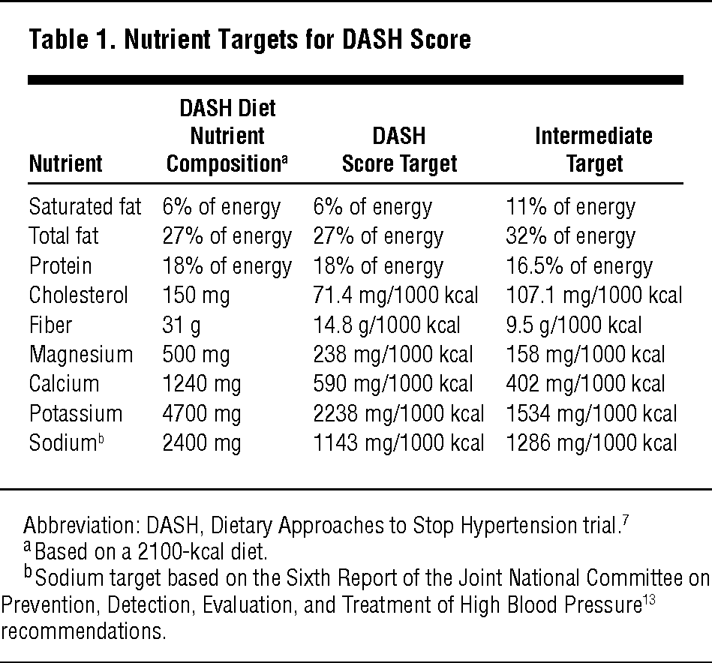

In [85]:
diet_df <- nhanes('DR1TOT_J')
nhanesTableVars('DIET', 'DR1TOT_J')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,DBD100,How often {do you/does SP} add this salt to {your/his/her/SP's} food at the table? Would you say . . .
2,DBQ095Z,What type of salt {do you/does SP} usually add to {your/his/her/SP's} food at the table? Would you say . . .
3,DR1_300,"Was the amount of food that {you/NAME} ate yesterday much more than usual, usual, or much less than usual?"
4,DR1_320Z,"Total plain water drank yesterday - including plain tap water, water from a drinking fountain, water from a water cooler, bottle"
5,DR1_330Z,Total tap water drank yesterday - including filtered tap water and water from a drinking fountain.
6,DR1BWATZ,Total bottled water drank yesterday (gm)
7,DR1DAY,Intake day of the week
8,DR1DBIH,Number of days between intake day and the day of family questionnaire administered in the household.
9,DR1DRSTZ,Dietary recall status


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1220 rows containing non-finite outside the scale range (`stat_bin()`).”


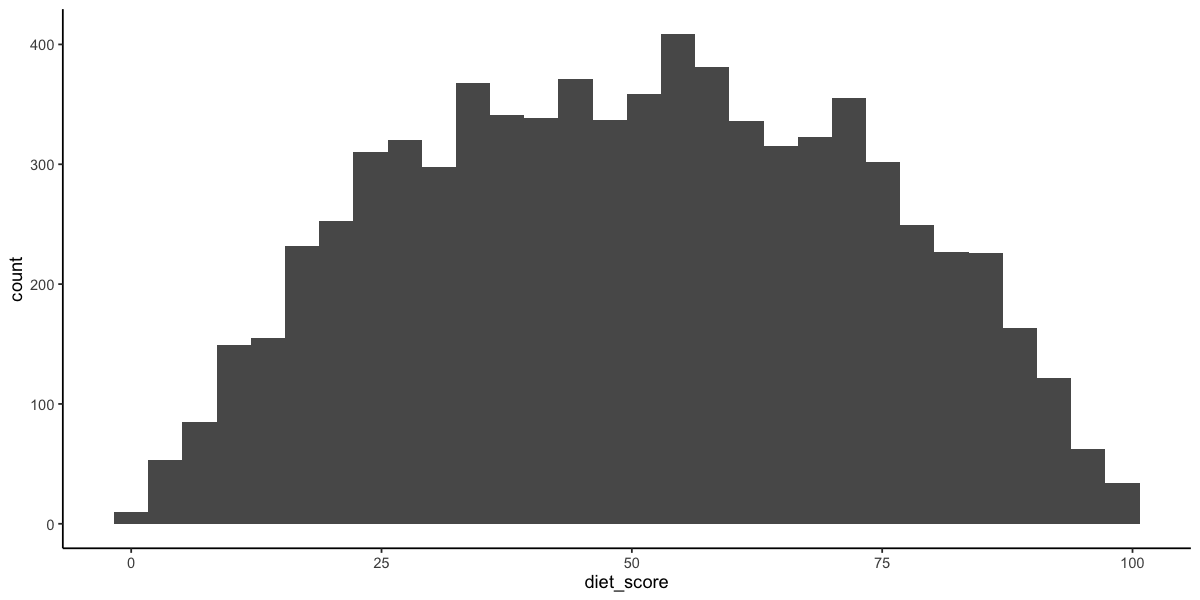

In [86]:
diet_df <- diet_df %>% mutate(
    diet_score = (
        ntile(DR1TSODI, 100) +
        ntile(DR1TSFAT, 100) +
        ntile(DR1TCHOL, 100) + 
        ntile(DR1TSUGR, 100)
    ) / 4
)

ggplot(diet_df) + geom_histogram(aes(x = diet_score))

## Sleep

In [87]:
nhanesSearch('sleep')

Variable.Name,Variable.Description,Data.File.Name,Data.File.Description,Begin.Year,EndYear,Component,Use.Constraints
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENQ010,{Do you/Does SP} currently have a breathing problem that requires {you/him/her} to use supplemental oxygen during the day? [This,SPX_E,Spirometry - Pre and Post-Bronchodilator,2007,2008,Examination,None
ENQ010,{Do you/Does SP} currently have a breathing problem that requires {you/him/her} to use supplemental oxygen during the day? [This,SPX_F,Spirometry - Pre and Post-Bronchodilator,2009,2010,Examination,None
ENQ010,{Do you/Does SP} currently have a breathing problem that requires {you/him/her} to use supplemental oxygen during the day? [This,SPX_G,Spirometry - Pre and Post-Bronchodilator,2011,2012,Examination,None
PAXAISMD,Day count: 80hz data in idle sleep mode,PAXDAY_G,Physical Activity Monitor - Day,2011,2012,Examination,None
PAXSWMD,Day sum: valid sleep wear minutes,PAXDAY_G,Physical Activity Monitor - Day,2011,2012,Examination,None
PAXAISMH,Hour count: 80hz data in idle sleep mode,PAXHR_G,Physical Activity Monitor - Hour,2011,2012,Examination,None
PAXSWMH,Hour sum: valid sleep wear minutes,PAXHR_G,Physical Activity Monitor - Hour,2011,2012,Examination,None
PAXAISMM,Minute count: 80hz data in idle sleep mode,PAXMIN_G,Physical Activity Monitor - Minute,2011,2012,Examination,None
PAXPREDM,Estimated wake/sleep/wear status during the minute,PAXMIN_G,Physical Activity Monitor - Minute,2011,2012,Examination,None


In [88]:
nhanesTableVars('Q', 'SLQ_J')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,SEQN,Respondent sequence number.
2,SLD012,Number of hours usually sleep on weekdays or workdays.
3,SLD013,Number of hours usually sleep on weekends or non-workdays.
4,SLQ030,"In the past 12 months, how often did {you/SP} snore while {you were/s/he was} sleeping?"
5,SLQ040,"In the past 12 months, how often did {you/SP} snort, gasp, or stop breathing while {you were/s/he was} asleep?"
6,SLQ050,{Have you/Has SP} ever told a doctor or other health professional that {you have/s/he has} trouble sleeping?
7,SLQ120,"In the past month, how often did {you/SP} feel excessively or overly sleepy during the day?"
8,SLQ300,What time {do you/does SP} usually fall asleep on weekdays or workdays?
9,SLQ310,What time {do you/does SP} usually wake up on weekdays or workdays?


Warning message:
“Removed 71 rows containing non-finite outside the scale range (`stat_bin()`).”


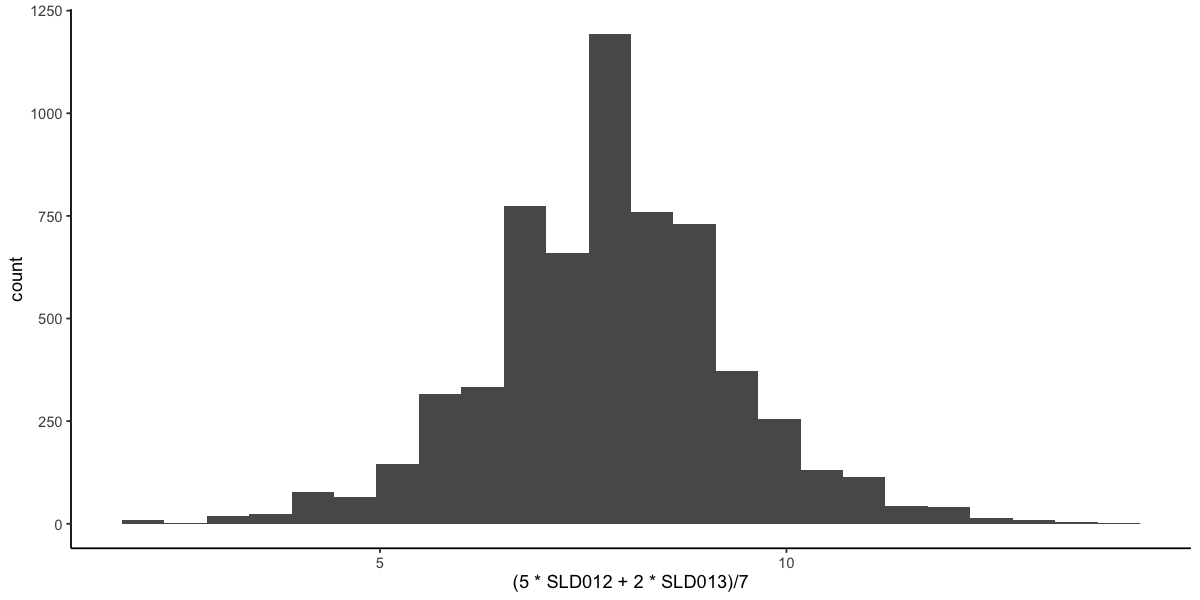

In [89]:
sl_df <- nhanes("SLQ_J")
ggplot(sl_df) + geom_histogram(aes(x = (5 * SLD012 + 2 * SLD013) / 7), bins=24)

In [90]:
sl_df <- mutate(sl_df, sleep_score = 100 - ntile(5 * SLD012 + 2 * SLD013, 100))

In [91]:
behav_df <- reduce(list(smq_df, diet_df, paq_df, sl_df), left_join, by="SEQN") %>% 
    mutate(behavior_score = (smoking_score + diet_score + activity_score + sleep_score))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1823 rows containing non-finite outside the scale range (`stat_bin()`).”


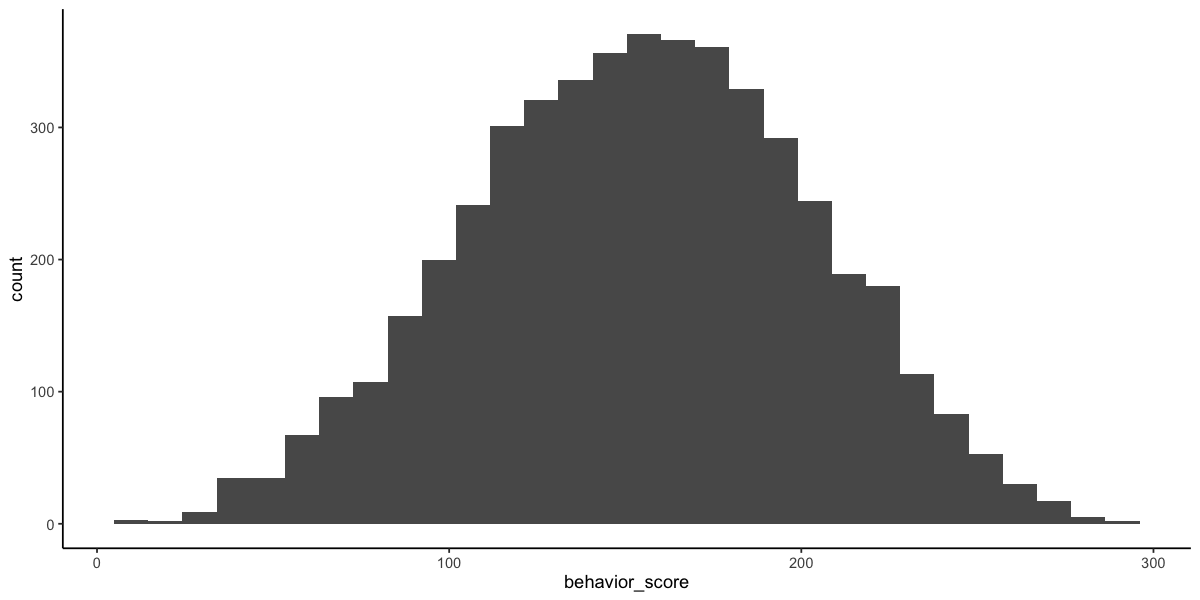

In [92]:
ggplot(behav_df) + geom_histogram(aes(x=behavior_score))

Joining with `by = join_by(SEQN)`
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


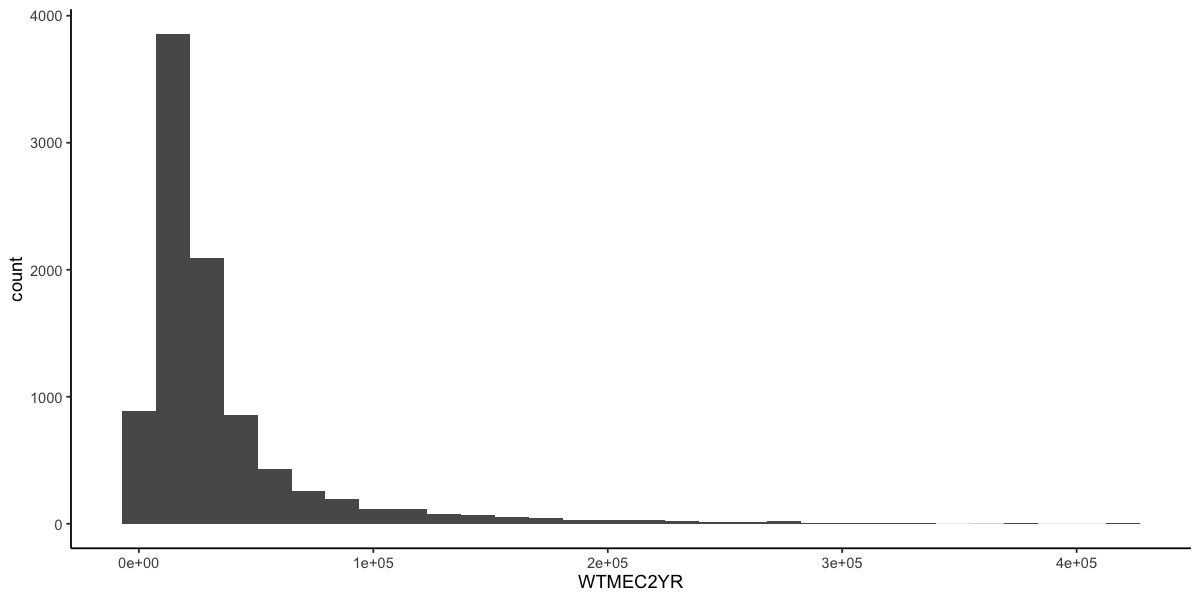

In [93]:
combined_df <- left_join(health_df, behav_df) %>% 
    mutate(lh8_score = (health_score + behavior_score) / 8)

combined_df %>% ggplot + geom_histogram(aes(x=WTMEC2YR))

Warning message:
“Removed 7285 rows containing non-finite outside the scale range (`stat_bin()`).”


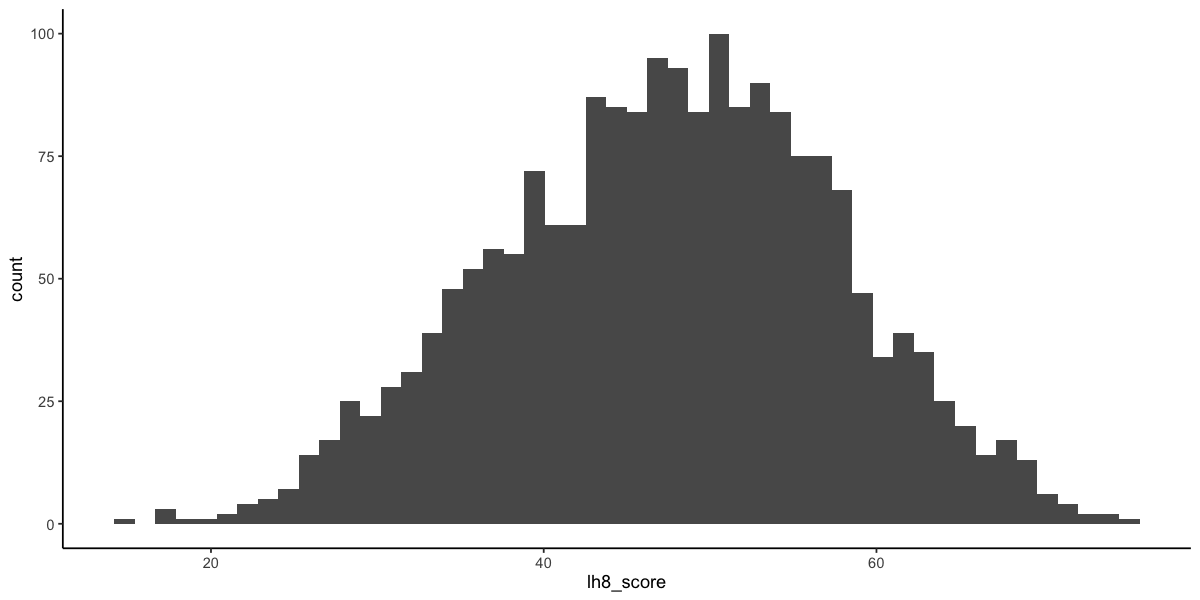

In [94]:
ggplot(combined_df) + geom_histogram(aes(x=lh8_score), bins=50)

## Correctly accounting for survey weights
- Remember that the NHANES data have a complicated weighting procedure. 
- ([Tutorial](https://wwwn.cdc.gov/nchs/nhanes/tutorials/weighting.aspx))
- We will use the built-in survey package to handle survey weights.

In [95]:
library(survey)

nhanesDesign <- svydesign(id = ~SDMVPSU,  # Primary Sampling Units (PSU)
                          strata  = ~SDMVSTRA, # Stratification used in the survey
                          weights = ~WTMEC2YR,   # Survey weights
                          nest    = TRUE,      # Whether PSUs are nested within strata
                          data    = combined_df)

In [96]:
# subset survey design object
dfsub = base::subset(nhanesDesign, combined_df$RIDAGEYR>=40)

# subset the original dataset
filtsub = filter(combined_df, RIDAGEYR>=40)



Let's see what this package does by comparing the adjusted and unadjusted means:

In [97]:
filtsub %>% summarize(mean(RIDAGEYR, na.rm=T))

svymean(~ RIDAGEYR, dfsub, na.rm=TRUE) # adjusted means

"mean(RIDAGEYR, na.rm = T)"
<dbl>
61.00515


           mean     SE
RIDAGEYR 58.989 0.4128

big difference!

### Quantiles
Similar to means, you get a (slightly) different answer depending on whether you account for weights or not:

In [98]:
quantile(combined_df$lh8_score, c(0.25,0.5,.75), na.rm = TRUE)

svyquantile(~ lh8_score, nhanesDesign, quantiles = c(0.25,0.5,0.75), na.rm=TRUE)

25%      50%      75% 
40.21875 47.87500 54.62500

$lh8_score
     quantile   ci.2.5  ci.97.5        se
0.25 40.21875 39.12500 41.96875 0.6670930
0.5  48.03125 46.84375 49.21875 0.5571326
0.75 54.93750 54.06250 55.96875 0.4471722

attr(,"hasci")
[1] TRUE
attr(,"class")
[1] "newsvyquantile"

### Survey regression
There is a special type of GLM that we can use to do regression with survey data. Compare:

In [99]:
lm(lh8_score ~ RIDAGEYR, data = combined_df) %>% summary


Call:
lm(formula = lh8_score ~ RIDAGEYR, data = combined_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.9898  -6.8566   0.2418   6.8750  30.1154 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 40.06613    0.63494   63.10   <2e-16 ***
RIDAGEYR     0.14916    0.01206   12.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.802 on 1967 degrees of freedom
  (7285 observations deleted due to missingness)
Multiple R-squared:  0.0722,	Adjusted R-squared:  0.07172 
F-statistic: 153.1 on 1 and 1967 DF,  p-value: < 2.2e-16


In [100]:
lm(lh8_score ~ RIDAGEYR + RIAGENDR * RIDRETH1, data = combined_df) %>% summary

# combined_df %>% colnames


Call:
lm(formula = lh8_score ~ RIDAGEYR + RIAGENDR * RIDRETH1, data = combined_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.4118  -6.7991   0.2527   6.4731  28.7545 

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                42.55638    0.98073
RIDAGEYR                                                    0.14582    0.01196
RIAGENDRFemale                                             -4.49088    1.13472
RIDRETH1Other Hispanic                                     -1.47855    1.36959
RIDRETH1Non-Hispanic White                                  0.08578    0.96745
RIDRETH1Non-Hispanic Black                                 -1.02925    1.05026
RIDRETH1Other Race - Including Multi-Racial                -0.61665    1.10044
RIAGENDRFemale:RIDRETH1Other Hispanic                       1.82036    1.84415
RIAGENDRFemale:RIDRETH1Non-Hispanic White                  -0.26780    1.34914
RIAGEND

### Interesting questions we can ask using these scores?

Warning message:
“Removed 3960 rows containing missing values or values outside the scale range
(`geom_point()`).”


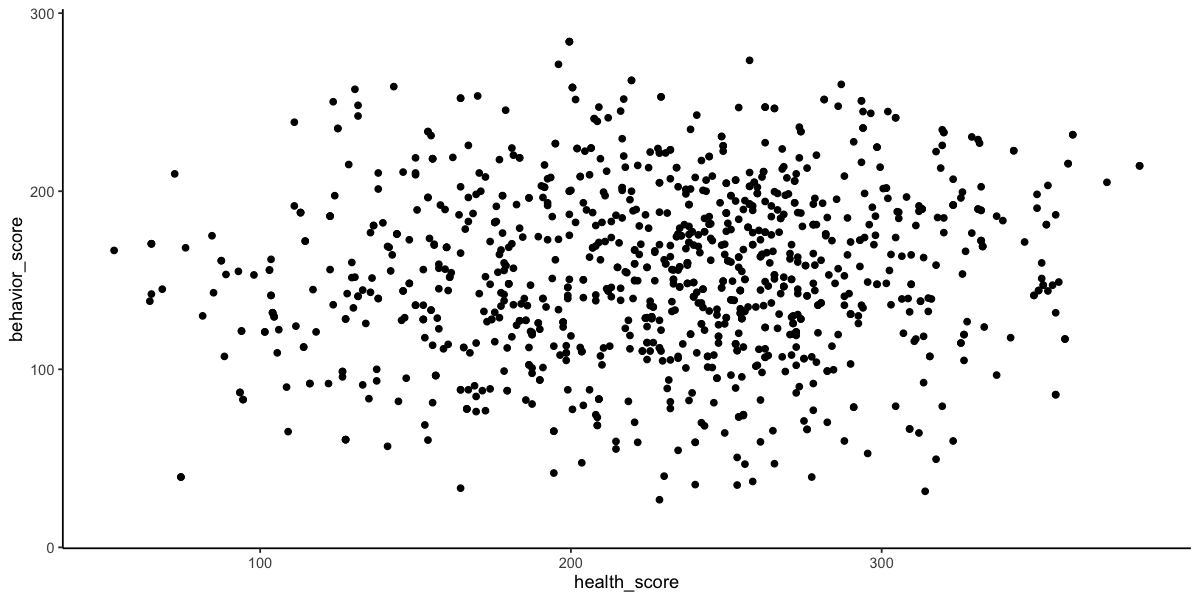

In [101]:
sdf <- sample_n(combined_df, replace=T, 5000, weights=WTMEC2YR) 
sdf %>% ggplot + geom_point(aes(x=health_score, y=behavior_score))

In [102]:
# how correlated are health_score and behavior_score?
lm(health_score ~ behavior_score, sdf) %>% summary


Call:
lm(formula = health_score ~ behavior_score, data = sdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-176.487  -42.381    6.568   41.164  147.391 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    207.99369    6.52131  31.894  < 2e-16 ***
behavior_score   0.12889    0.04008   3.216  0.00134 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 62.3 on 1038 degrees of freedom
  (3960 observations deleted due to missingness)
Multiple R-squared:  0.009867,	Adjusted R-squared:  0.008914 
F-statistic: 10.34 on 1 and 1038 DF,  p-value: 0.001339


Warning message:
“Removed 3960 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


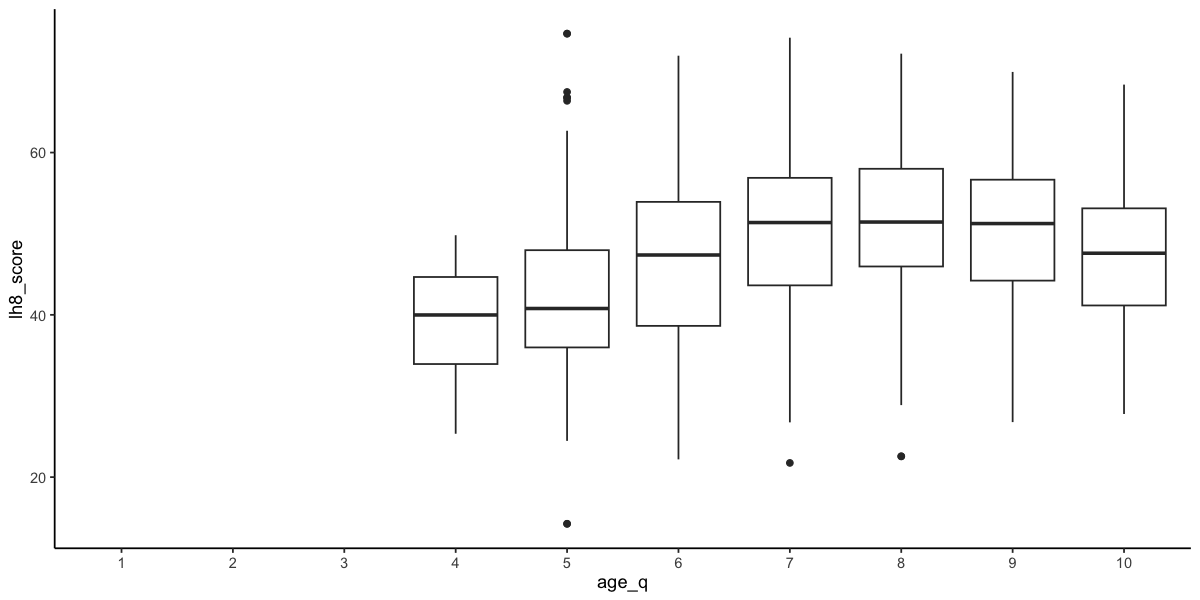

In [103]:
# health scores by age range
sdf  %>% mutate(age_q = factor(ntile(RIDAGEYR, 10))) %>% 
    ggplot + geom_boxplot(aes(x=age_q, y=lh8_score))

Warning message:
“Removed 3960 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


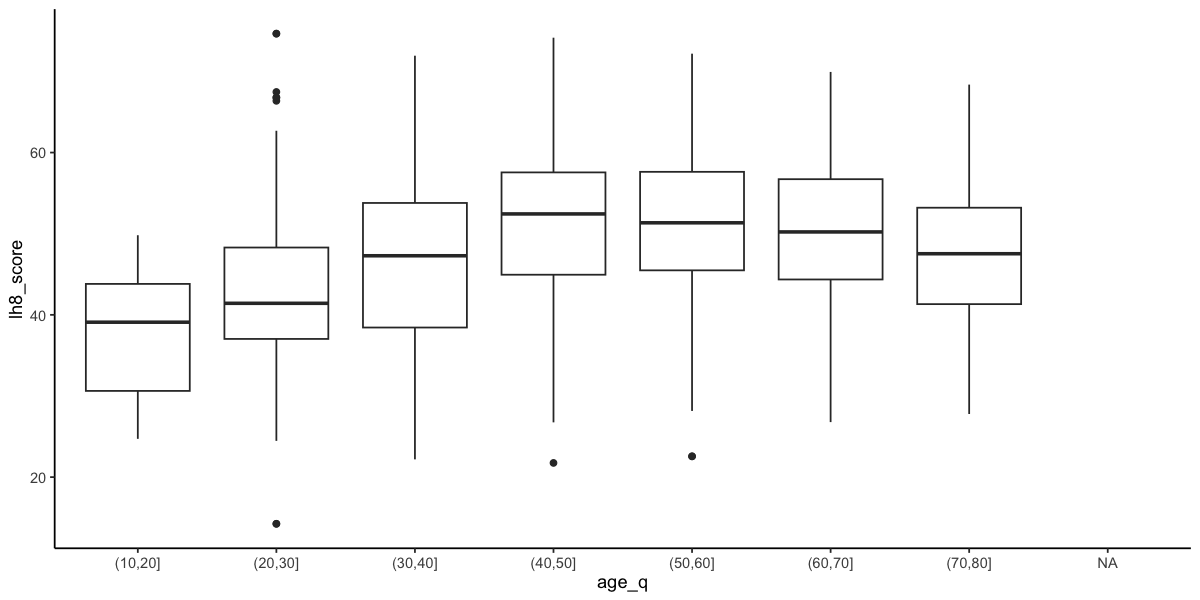

In [104]:
# health scores by age range
sdf %>% mutate(age_q = cut(RIDAGEYR, seq(10, 100, 10))) %>% 
    ggplot + geom_boxplot(aes(x=age_q, y=lh8_score))

Warning message:
“Removed 3960 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


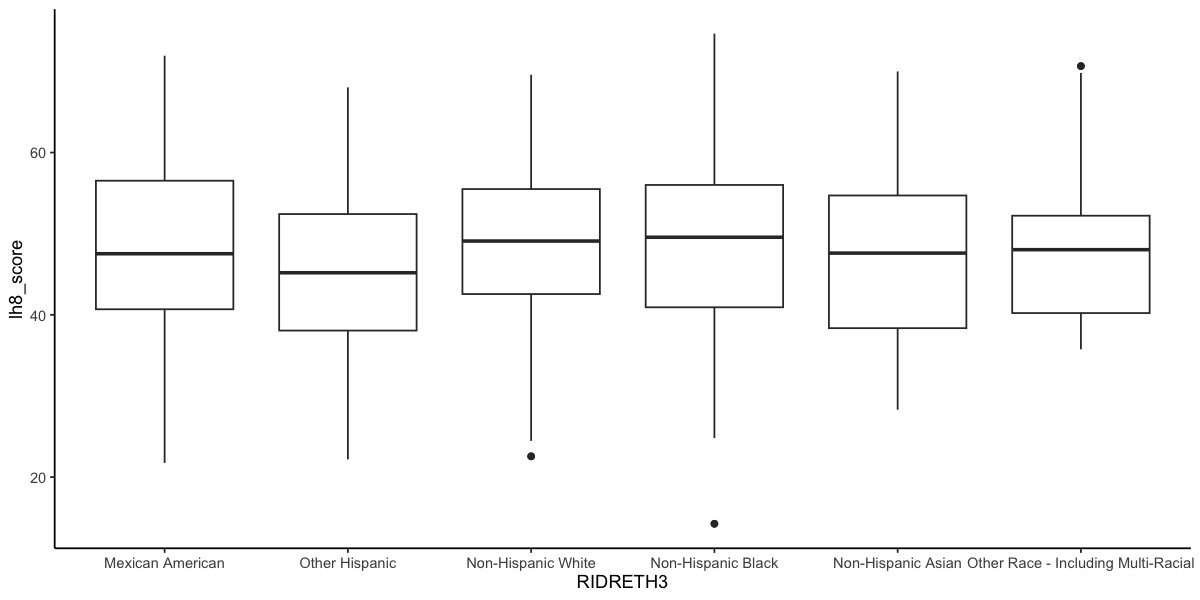

In [105]:
# health scores by age range
sdf %>% 
    ggplot + geom_boxplot(aes(x=RIDRETH3, y=lh8_score))

Warning message:
“Removed 3960 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


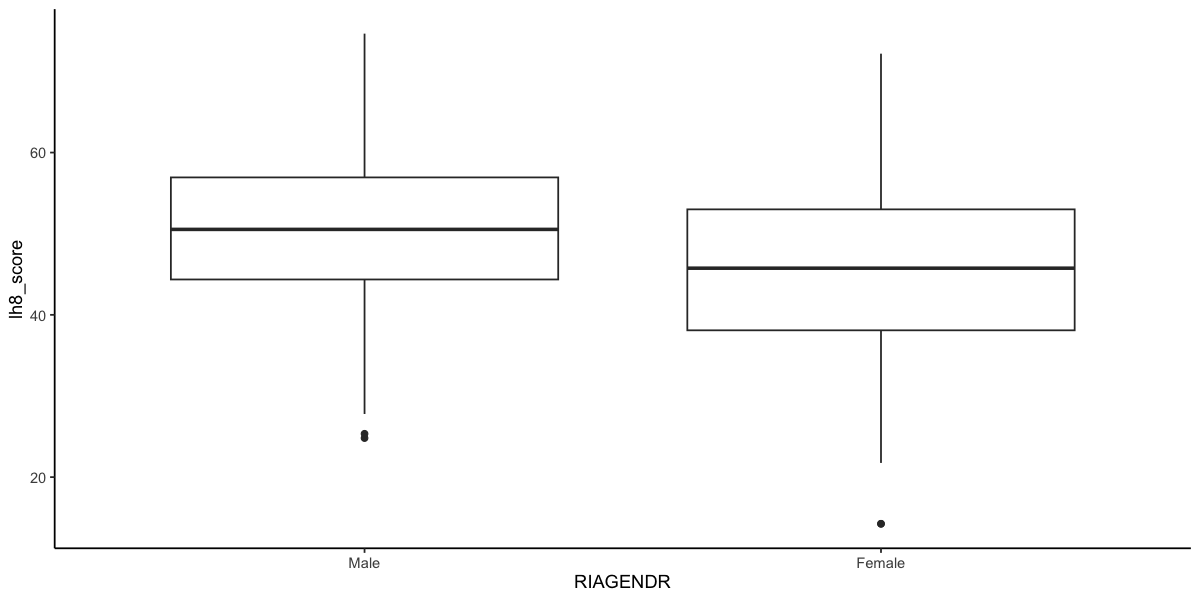

In [106]:
# health scores by age range
sdf %>% 
    ggplot + geom_boxplot(aes(x=RIAGENDR, y=lh8_score))